# CP1 - TMDB Box Office Prediction

# Introduction

In a world... where movies made an estimated $41.7 billion in 2018, the film industry is more popular than ever. But what movies make the most money at the box office? How much does a director matter? Or the budget? For some movies, it's "You had me at 'Hello.'" For others, the trailer falls short of expectations and you think "What we have here is a failure to communicate."

In this dataset from Kaggle competition, you're presented with metadata on over 7,000 past films from The Movie Database to try and predict their overall worldwide box office revenue. Data points provided include cast, crew, plot keywords, budget, posters, release dates, languages, production companies, and countries.

During this process we will be going through:
1. Exploratory data analysis,
2. Feature engineering,
3. Treating missing values, and
4. Machine learning using regression, xgboost.

First lets load all the packages that we will need.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import math
import ast

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from sklearn import metrics
from sklearn.impute import KNNImputer
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from yellowbrick.regressor import ResidualsPlot
from datetime import datetime


C:\Users\Brainz\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


Read in the train and test data sets. 

In [2]:
# read dataset
train=pd.read_csv('input/train.csv')
test=pd.read_csv('input/test.csv')

# Data Overview

Lets check train and test datasets. We use function info(), shape and head() to explore the dataframe.

In [3]:
train.head(5)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


**The description of features:**  
**Data Description id** - Integer unique id of each movie  
**belongs_to_collection** - Contains the TMDB Id, Name, Movie Poster and Backdrop URL of a movie in JSON format.   
**budget** - Budget of a movie in dollars. 0 values mean unknown.  
**genres** - Contains all the Genres Name & TMDB Id in JSON Format  
**homepage** - Contains the official homepage URL of a movie.   
**imdb_id** - IMDB id of a movie (string).   
**original_language** - Two digit code of the original language, in which the movie was made. Like: en = English, fr = french.  
**original_title** - The original title of a movie. Title & Original title may differ, if the original title is not in English.  
**overview** - Brief description of the movie.  
**popularity** - Popularity of the movie in float.  
**poster_path** - Poster path of a movie.   
**production_companies** - All production company name and TMDB id in JSON format of a movie.  
**production_countries** - Two digit code and full name of the production company in JSON format.  
**release_date** - Release date of a movie in mm/dd/yy format.  
**runtime** - Total runtime of a movie in minutes (Integer).  
**spoken_languages** - Two digit code and full name of the spoken language.  
**status** - Is the movie released or rumored?  
**tagline** - Tagline of a movie  
**title** - English title of a movie  
**Keywords** - TMDB Id and name of all the keywords in JSON format.  
**cast** - All cast TMDB id, name, character name, gender (1 = Female, 2 = Male) in JSON format  
**crew** - Name, TMDB id, profile path of various kind of crew members job like Director, Writer, Art, Sound etc.  
**revenue** - Total revenue earned by a movie in dollars.  

In [4]:
print("Dimension of train : " + str(train.shape) + " || Dimension of test : " + str(test.shape))

Dimension of train : (3000, 23) || Dimension of test : (4398, 22)


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
id                       3000 non-null int64
belongs_to_collection    604 non-null object
budget                   3000 non-null int64
genres                   2993 non-null object
homepage                 946 non-null object
imdb_id                  3000 non-null object
original_language        3000 non-null object
original_title           3000 non-null object
overview                 2992 non-null object
popularity               3000 non-null float64
poster_path              2999 non-null object
production_companies     2844 non-null object
production_countries     2945 non-null object
release_date             3000 non-null object
runtime                  2998 non-null float64
spoken_languages         2980 non-null object
status                   3000 non-null object
tagline                  2403 non-null object
title                    3000 non-null object
Keywords             

Lets count NAs per column in the dataframe

In [6]:
print("Count NA Train per column : \n" + str(train.isna().sum().sort_values(ascending=False)))

Count NA Train per column : 
belongs_to_collection    2396
homepage                 2054
tagline                   597
Keywords                  276
production_companies      156
production_countries       55
spoken_languages           20
crew                       16
cast                       13
overview                    8
genres                      7
runtime                     2
poster_path                 1
original_language           0
budget                      0
imdb_id                     0
revenue                     0
original_title              0
popularity                  0
release_date                0
status                      0
title                       0
id                          0
dtype: int64


Lets join two datasets. We will do all feature engineering and data preparation on both data sets and then divide our data into train and test sets again later before creating our model.

In [7]:
train['dataset']='train'
test['dataset']='test'
master=train.append(test, sort=False)
master.tail(5)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,dataset
4393,7394,NaN,42000000,"[{'id': 53, 'name': 'Thriller'}]",NaN,tt0218922,en,Original Sin,A young man is plunged into a life of subterfu...,9.970359,...,118.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,This is not a love story - it's a story about ...,Original Sin,"[{'id': 515, 'name': 'women'}, {'id': 572, 'na...","[{'cast_id': 17, 'character': 'Julia Russell/B...","[{'credit_id': '52fe4330c3a36847f80412db', 'de...",NaN,test
4394,7395,"[{'id': 146534, 'name': 'Without a Paddle Coll...",19000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,tt0364751,en,Without a Paddle,"Three friends, whose lives have been drifting ...",6.046516,...,95.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"The call of the wild, the thrill of adventure....",Without a Paddle,"[{'id': 4959, 'name': 'death of a friend'}, {'...","[{'cast_id': 40, 'character': 'Dan Mott', 'cre...","[{'credit_id': '52fe43b29251416c7501a909', 'de...",NaN,test
4395,7396,NaN,16000000,"[{'id': 18, 'name': 'Drama'}]",NaN,tt0084855,en,The Verdict,"Frank Galvin is a down-on-his luck lawyer, red...",9.596883,...,129.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"The doctors want to settle, the Church wants t...",The Verdict,"[{'id': 1680, 'name': 'boston'}, {'id': 6148, ...","[{'cast_id': 1, 'character': 'Frank Galvin', '...","[{'credit_id': '52fe448bc3a368484e028c55', 'de...",NaN,test
4396,7397,NaN,2000000,"[{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...",NaN,tt3235888,en,It Follows,"For 19-year-old Jay, fall should be about scho...",20.359336,...,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"It doesn't think, it doesn't feel, it doesn't ...",It Follows,"[{'id': 3713, 'name': 'chase'}, {'id': 6152, '...","[{'cast_id': 1, 'character': 'Jay Height', 'cr...","[{'credit_id': '537770b20e0a261431002299', 'de...",NaN,test
4397,7398,NaN,64000,"[{'id': 18, 'name': 'Drama'}]",NaN,tt0056663,fr,Vivre sa vie: film en douze tableaux,Twelve episodic tales in the life of a Parisia...,11.305910,...,85.0,"[{'iso_639_1': 'fr', 'name': 'Français'}]",Released,The many faces of a woman trying to find herse...,Vivre Sa Vie,"[{'id': 90, 'name': 'paris'}, {'id': 490, 'nam...","[{'cast_id': 8, 'character': 'Nana Kleinfranke...","[{'credit_id': '52fe4306c3a36847f80349a5', 'de...",NaN,test


# Data Cleaning

We can see that some of columns contain lists with dictionaries. Some lists contain a single dictionary, some have several. Let's extract data from these columns!

### belongs_to_collection

In [8]:
for i, e in enumerate(master['belongs_to_collection'][:5]):
    print(i, e)

0 [{'id': 313576, 'name': 'Hot Tub Time Machine Collection', 'poster_path': '/iEhb00TGPucF0b4joM1ieyY026U.jpg', 'backdrop_path': '/noeTVcgpBiD48fDjFVic1Vz7ope.jpg'}]
1 [{'id': 107674, 'name': 'The Princess Diaries Collection', 'poster_path': '/wt5AMbxPTS4Kfjx7Fgm149qPfZl.jpg', 'backdrop_path': '/zSEtYD77pKRJlUPx34BJgUG9v1c.jpg'}]
2 nan
3 nan
4 nan


Lets create function text_to_dict to convert columns to dictionary.

In [9]:
dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']
#access the dictionaries
def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df
        
dfx = text_to_dict(master)
for col in dict_columns:
       master[col]=dfx[col]

In [10]:
master['belongs_to_collection'].apply(lambda x:len(x) if x!= {} else 0).value_counts()

0    5917
1    1481
Name: belongs_to_collection, dtype: int64

We create two new columns from column "belongs_to collection", first one is collection name and second one has collection or not. We assume that other information from this column we cant use for futher prediction. 

In [11]:
master['collection_name'] = master['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
master['has_collection'] = master['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)

master = master.drop(['belongs_to_collection'], axis=1)

### genres

In [12]:
for i, e in enumerate(master['genres'][:5]):
    print(i, e)

0 [{'id': 35, 'name': 'Comedy'}]
1 [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10751, 'name': 'Family'}, {'id': 10749, 'name': 'Romance'}]
2 [{'id': 18, 'name': 'Drama'}]
3 [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'name': 'Drama'}]
4 [{'id': 28, 'name': 'Action'}, {'id': 53, 'name': 'Thriller'}]


In [13]:
print('Number of genres in films')
master['genres'].apply(lambda x: len(x) if x != {} else 0).value_counts()

Number of genres in films


2    2379
3    2208
1    1488
4     967
5     280
6      48
0      23
7       4
8       1
Name: genres, dtype: int64

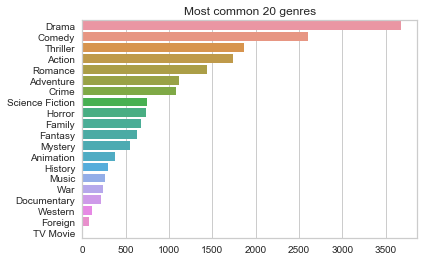

In [14]:
genre=master['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else [])
count=Counter([i for j in genre for i in j]).most_common(20)
_=sns.barplot([val[1] for val in count],[val[0] for val in count]).set_title('Most common 20 genres')


From chart we can observe that most common genre is drama. We will create dummy variable for these 20 genres.

In [15]:
# create columns all genres and number of genres
master['all_genres'] = master['genres'].apply(lambda x: sorted([i['name'] for i in x]) if x != {} else '')
master['num_genres']=master['genres'].apply(lambda x: len(x) if x != {} else 0)
#create dummy variables
list_of_genres = list(master['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
top_genres = [m[0] for m in Counter([i for j in list_of_genres for i in j]).most_common(15)]
all_genress = list(Counter([i for j in list_of_genres for i in j]))
others_genres=list(set(all_genress)-set(top_genres))
for g in top_genres:
    master[g] = master['all_genres'].apply(lambda x: 1 if g in x else 0)
for g in others_genres:
    master['genres_others'] = master['all_genres'].apply(lambda x: 1 if g in x else 0)

master = master.drop(['genres','all_genres'], axis=1)

### production companies

In [16]:
for i, e in enumerate(master['production_companies'][:5]):
    print(i, e)

0 [{'name': 'Paramount Pictures', 'id': 4}, {'name': 'United Artists', 'id': 60}, {'name': 'Metro-Goldwyn-Mayer (MGM)', 'id': 8411}]
1 [{'name': 'Walt Disney Pictures', 'id': 2}]
2 [{'name': 'Bold Films', 'id': 2266}, {'name': 'Blumhouse Productions', 'id': 3172}, {'name': 'Right of Way Films', 'id': 32157}]
3 {}
4 {}


In [17]:
print('Number of production companies in films')
master['production_companies'].apply(lambda x: len(x) if x != {} else 0).value_counts()

Number of production companies in films


1     1905
2     1786
3     1373
4      785
5      430
0      414
6      295
7      156
8       91
9       74
11      24
10      22
12       8
16       8
13       6
14       5
19       3
15       3
17       2
18       2
21       2
24       1
20       1
22       1
26       1
Name: production_companies, dtype: int64

Again we will create dummy variables for most common production companies.

In [18]:
master['all_pd_com'] = master['production_companies'].apply(lambda x: sorted([i['name'] for i in x]) if x != {} else '')
master['num_pd_com']=master['production_companies'].apply(lambda x: len(x) if x != {} else 0)
#create dummy variables
list_of_companies = list(master['production_companies'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
top_companies = [m[0] for m in Counter([i for j in list_of_companies for i in j]).most_common(30)]
all_pd_coms = list(Counter([i for j in list_of_companies for i in j]))
others_pd_com=list(set(all_pd_coms)-set(top_companies))

for g in top_companies:
    master['pd_com_' + g] = master['all_pd_com'].apply(lambda x: 1 if g in x else 0)
for g in others_pd_com:
    master['pd_com_others'] = master['all_pd_com'].apply(lambda x: 1 if g in x else 0)

master = master.drop(['production_companies', 'all_pd_com'], axis=1)

### production countries 

In [19]:
for i, e in enumerate(master['production_countries'][:5]):
    print(i, e)

0 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
1 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
2 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
3 [{'iso_3166_1': 'IN', 'name': 'India'}]
4 [{'iso_3166_1': 'KR', 'name': 'South Korea'}]


In [20]:
print('Number of production countries in films')
master['production_countries'].apply(lambda x: len(x) if x != {} else 0).value_counts()

Number of production countries in films


1     5464
2     1227
3      361
0      157
4      128
5       42
6       11
8        3
9        2
7        1
10       1
12       1
Name: production_countries, dtype: int64

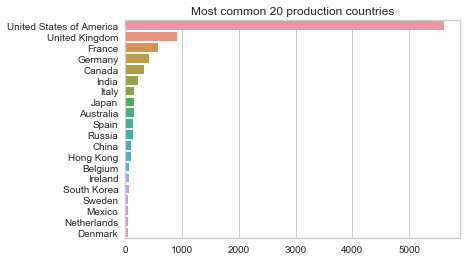

In [21]:
list_of_countries = list(master['production_countries'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
count=Counter([i for j in list_of_countries for i in j]).most_common(20)
_=sns.barplot([val[1] for val in count],[val[0] for val in count]).set_title('Most common 20 production countries')

As we can see USA is the most common production country. We will create dummy variables for these countries.

In [22]:
master['num_pd_cnt'] = master['production_countries'].apply(lambda x: len(x) if x != {} else 0)
master['all_pd_cnt']=master['production_countries'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
#create dummy variables
top_countries = [m[0] for m in Counter([i for j in list_of_countries for i in j]).most_common(25)]
all_pd_cnts = list(Counter([i for j in list_of_countries for i in j]))
others_pd_cnt=list(set(all_pd_cnts)-set(top_countries))
master['all_pd_cnt']
for g in top_countries:
    master['pd_cnt_' + g] = master['all_pd_cnt'].apply(lambda x: 1 if g in x else 0)    
for g in others_pd_cnt:
    master['pd_cnt_others'] = master['all_pd_cnt'].apply(lambda x: 1 if g in x else 0)
    
master = master.drop(['production_countries', 'all_pd_cnt'], axis=1)

### spoken languages

In [23]:
for i, e in enumerate(master['spoken_languages'][:5]):
    print(i, e)

0 [{'iso_639_1': 'en', 'name': 'English'}]
1 [{'iso_639_1': 'en', 'name': 'English'}]
2 [{'iso_639_1': 'en', 'name': 'English'}]
3 [{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'hi', 'name': 'हिन्दी'}]
4 [{'iso_639_1': 'ko', 'name': '한국어/조선말'}]


In [24]:
print('Number of spoken languages in films')
master['spoken_languages'].apply(lambda x: len(x) if x != {} else 0).value_counts()

Number of spoken languages in films


1    5226
2    1319
3     502
4     178
5      73
0      62
6      25
7       6
8       4
9       3
Name: spoken_languages, dtype: int64

In [25]:
list_of_languages = list(master['spoken_languages'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_languages for i in j]).most_common(10)

[('English', 6449),
 ('Français', 711),
 ('Español', 559),
 ('Deutsch', 419),
 ('Pусский', 364),
 ('Italiano', 321),
 ('日本語', 204),
 ('普通话', 163),
 ('हिन्दी', 160),
 ('', 114)]

In [26]:
master['num_lg'] = master['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)
master['all_lg'] = master['spoken_languages'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
#create dummy variables
top_languages = [m[0] for m in Counter([i for j in list_of_languages for i in j]).most_common(30)]
all_lgs = list(Counter([i for j in list_of_languages for i in j]))
others_lg=list(set(all_lgs)-set(top_languages))
for g in top_languages:
    master['lg_' + g] = master['all_lg'].apply(lambda x: 1 if g in x else 0)
for g in others_lg:
    master['lg_others'] = master['all_lg'].apply(lambda x: 1 if g in x else 0)
    
master = master.drop(['spoken_languages', 'all_lg'], axis=1)

### Keywords

In [27]:
for i, e in enumerate(master['Keywords'][:3]):
    print(i, e)

0 [{'id': 4379, 'name': 'time travel'}, {'id': 9663, 'name': 'sequel'}, {'id': 11830, 'name': 'hot tub'}, {'id': 179431, 'name': 'duringcreditsstinger'}]
1 [{'id': 2505, 'name': 'coronation'}, {'id': 4263, 'name': 'duty'}, {'id': 6038, 'name': 'marriage'}, {'id': 13072, 'name': 'falling in love'}]
2 [{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'name': 'obsession'}, {'id': 1640, 'name': 'conservatory'}, {'id': 2176, 'name': 'music teacher'}, {'id': 14512, 'name': 'new york city'}, {'id': 14819, 'name': 'violence'}, {'id': 33896, 'name': 'montage'}, {'id': 156823, 'name': 'drummer'}, {'id': 170418, 'name': 'public humiliation'}, {'id': 176095, 'name': 'jazz band'}, {'id': 206298, 'name': 'young adult'}, {'id': 207739, 'name': 'music school'}]


In [28]:
print('Number of Keywords in films')
master['Keywords'].apply(lambda x: len(x) if x != {} else 0).value_counts().head(10)

Number of Keywords in films


5    722
0    669
4    602
3    588
6    585
7    495
2    467
1    452
8    389
9    337
Name: Keywords, dtype: int64

In [29]:
list_of_keywords = list(master['Keywords'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
master['num_key'] = master['Keywords'].apply(lambda x: len(x) if x != {} else 0)
master['all_key'] = master['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
#create dummy variables
top_keywords = [m[0] for m in Counter([i for j in list_of_keywords for i in j]).most_common(30)]
all_keys = list(Counter([i for j in list_of_keywords for i in j]))
others_key=list(set(all_keys)-set(top_keywords))
for g in top_keywords:
    master['key_' + g] = master['all_key'].apply(lambda x: 1 if g in x else 0)
for g in others_key:
    master['key_others'] = master['all_key'].apply(lambda x: 1 if g in x else 0)

master = master.drop(['Keywords', 'all_key'], axis=1)

### cast

In [30]:
for i, e in enumerate(master['cast'][:1]):
    print(i, e)

0 [{'cast_id': 4, 'character': 'Lou', 'credit_id': '52fe4ee7c3a36847f82afae7', 'gender': 2, 'id': 52997, 'name': 'Rob Corddry', 'order': 0, 'profile_path': '/k2zJL0V1nEZuFT08xUdOd3ucfXz.jpg'}, {'cast_id': 5, 'character': 'Nick', 'credit_id': '52fe4ee7c3a36847f82afaeb', 'gender': 2, 'id': 64342, 'name': 'Craig Robinson', 'order': 1, 'profile_path': '/tVaRMkJXOEVhYxtnnFuhqW0Rjzz.jpg'}, {'cast_id': 6, 'character': 'Jacob', 'credit_id': '52fe4ee7c3a36847f82afaef', 'gender': 2, 'id': 54729, 'name': 'Clark Duke', 'order': 2, 'profile_path': '/oNzK0umwm5Wn0wyEbOy6TVJCSBn.jpg'}, {'cast_id': 7, 'character': 'Adam Jr.', 'credit_id': '52fe4ee7c3a36847f82afaf3', 'gender': 2, 'id': 36801, 'name': 'Adam Scott', 'order': 3, 'profile_path': '/5gb65xz8bzd42yjMAl4zwo4cvKw.jpg'}, {'cast_id': 8, 'character': 'Hot Tub Repairman', 'credit_id': '52fe4ee7c3a36847f82afaf7', 'gender': 2, 'id': 54812, 'name': 'Chevy Chase', 'order': 4, 'profile_path': '/svjpyYtPwtjvRxX9IZnOmOkhDOt.jpg'}, {'cast_id': 9, 'characte

In [31]:
print('Number of casted persons in films')
master['cast'].apply(lambda x: len(x) if x != {} else 0).value_counts().head(5)

Number of casted persons in films


15    525
16    379
12    328
11    325
13    324
Name: cast, dtype: int64

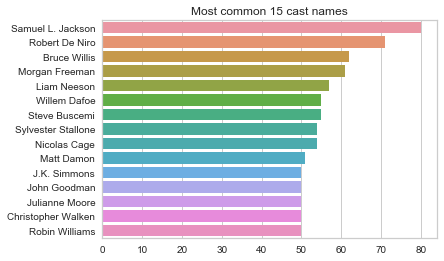

In [32]:
list_of_cast_names = list(master['cast'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
count=Counter([i for j in list_of_cast_names for i in j]).most_common(15)
_=sns.barplot([val[1] for val in count],[val[0] for val in count]).set_title('Most common 15 cast names')

Most common actor is Samuel Jackson.

In [33]:
#0 is unspecified, 1 is female, 2 is male
list_of_cast_genders = list(master['cast'].apply(lambda x: [i['gender'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_cast_genders for i in j]).most_common()

[(2, 69023), (0, 52020), (1, 33991)]

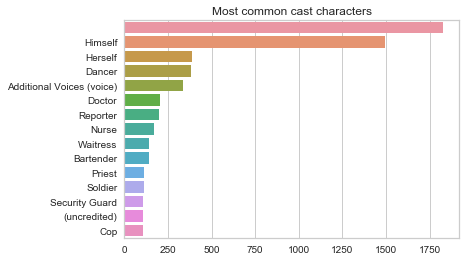

In [34]:
list_of_cast_characters = list(master['cast'].apply(lambda x: [i['character'] for i in x] if x != {} else []).values)
count=Counter([i for j in list_of_cast_characters for i in j]).most_common(15)
_=sns.barplot([val[1] for val in count],[val[0] for val in count]).set_title('Most common cast characters')

Suprprisingly, that they played mostly himself or herself.

In [35]:
master['num_cast'] = master['cast'].apply(lambda x: len(x) if x != {} else 0)
top_cast_names = [m[0] for m in Counter([i for j in list_of_cast_names for i in j]).most_common(15)]

for g in top_cast_names:
    master['cast_name_' + g] = master['cast'].apply(lambda x: 1 if g in str(x) else 0)
  
master['genders_0_cast'] = master['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
master['genders_1_cast'] = master['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
master['genders_2_cast'] = master['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))

top_cast_characters = [m[0] for m in Counter([i for j in list_of_cast_characters for i in j]).most_common(15)]

for g in top_cast_characters:
    master['cast_chr_' + g] = master['cast'].apply(lambda x: 1 if g in str(x) else 0)

master = master.drop(['cast'], axis=1)

### crew

In [36]:
for i, e in enumerate(master['crew'][:1]):
    print(i, e[:10])

0 [{'credit_id': '59ac067c92514107af02c8c8', 'department': 'Directing', 'gender': 0, 'id': 1449071, 'job': 'First Assistant Director', 'name': 'Kelly Cantley', 'profile_path': None}, {'credit_id': '52fe4ee7c3a36847f82afad7', 'department': 'Directing', 'gender': 2, 'id': 3227, 'job': 'Director', 'name': 'Steve Pink', 'profile_path': '/myHOgo8mQSCiCAZNGMRdHVr03jr.jpg'}, {'credit_id': '5524ed25c3a3687ded000d88', 'department': 'Writing', 'gender': 2, 'id': 347335, 'job': 'Writer', 'name': 'Josh Heald', 'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'}, {'credit_id': '5524ed2d925141720c001128', 'department': 'Writing', 'gender': 2, 'id': 347335, 'job': 'Characters', 'name': 'Josh Heald', 'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'}, {'credit_id': '5524ed3d92514166c1004a5d', 'department': 'Production', 'gender': 2, 'id': 57822, 'job': 'Producer', 'name': 'Andrew Panay', 'profile_path': None}, {'credit_id': '5524ed4bc3a3687df3000dd2', 'department': 'Production', 'gender': 0, 'id': 14

In [37]:
print('Number of casted persons in films')
master['crew'].apply(lambda x: len(x) if x != {} else 0).value_counts().head(5)

Number of casted persons in films


2     394
3     338
10    316
11    281
8     274
Name: crew, dtype: int64

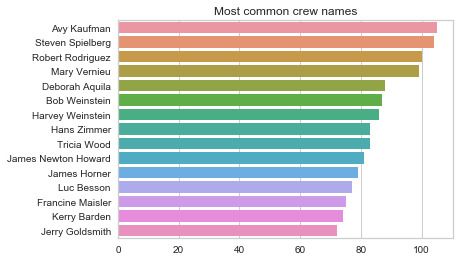

In [38]:
list_of_crew_names = list(master['crew'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
count=Counter([i for j in list_of_crew_names for i in j]).most_common(15)
_=sns.barplot([val[1] for val in count],[val[0] for val in count]).set_title('Most common crew names')

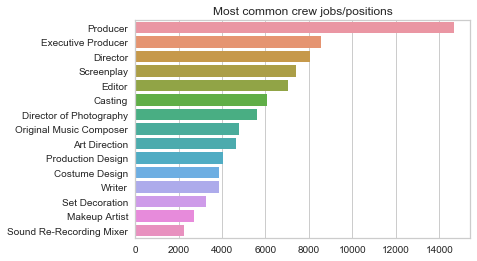

In [39]:
list_of_crew_jobs = list(master['crew'].apply(lambda x: [i['job'] for i in x] if x != {} else []).values)

count=Counter([i for j in list_of_crew_jobs for i in j]).most_common(15)
_=sns.barplot([val[1] for val in count],[val[0] for val in count]).set_title('Most common crew jobs/positions')

In [40]:
list_of_crew_genders = list(master['crew'].apply(lambda x: [i['gender'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_genders for i in j]).most_common(15)

[(0, 103439), (2, 60731), (1, 15420)]

In [41]:
list_of_crew_departments = list(master['crew'].apply(lambda x: [i['department'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_departments for i in j]).most_common(14)

[('Production', 38927),
 ('Sound', 22497),
 ('Art', 19870),
 ('Crew', 17529),
 ('Writing', 16329),
 ('Costume & Make-Up', 15223),
 ('Camera', 13229),
 ('Directing', 12245),
 ('Editing', 11135),
 ('Visual Effects', 9472),
 ('Lighting', 3129),
 ('Actors', 5)]

As we can see Production department is most common department in this dataset.

In [42]:
master['num_crew'] = master['crew'].apply(lambda x: len(x) if x != {} else 0)
top_crew_names = [m[0] for m in Counter([i for j in list_of_crew_names for i in j]).most_common(15)]

for g in top_crew_names:
    master['crew_name_' + g] = master['crew'].apply(lambda x: 1 if g in str(x) else 0)

master['genders_0_crew'] = master['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
master['genders_1_crew'] = master['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
master['genders_2_crew'] = master['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))

top_crew_jobs = [m[0] for m in Counter([i for j in list_of_crew_jobs for i in j]).most_common(15)]

for j in top_crew_jobs:
    master['jobs_' + j] = master['crew'].apply(lambda x: sum([1 for i in x if i['job'] == j]))
    
top_crew_departments = [m[0] for m in Counter([i for j in list_of_crew_departments for i in j]).most_common(15)]

for j in top_crew_departments:
    master['deps_' + j] = master['crew'].apply(lambda x: sum([1 for i in x if i['department'] == j])) 

master = master.drop(['crew'], axis=1)

### original_language

In [43]:
for i, e in enumerate(master['original_language'][:5]):
    print(i, e[:10])

0 en
1 en
2 en
3 hi
4 ko


In [44]:
master.original_language.mode(4)

0    en
dtype: object

We will not create for this column dummy variable, because "english" is the most common language.

# Data Exploration

Let first look at the histograms of the target feature - revenue.

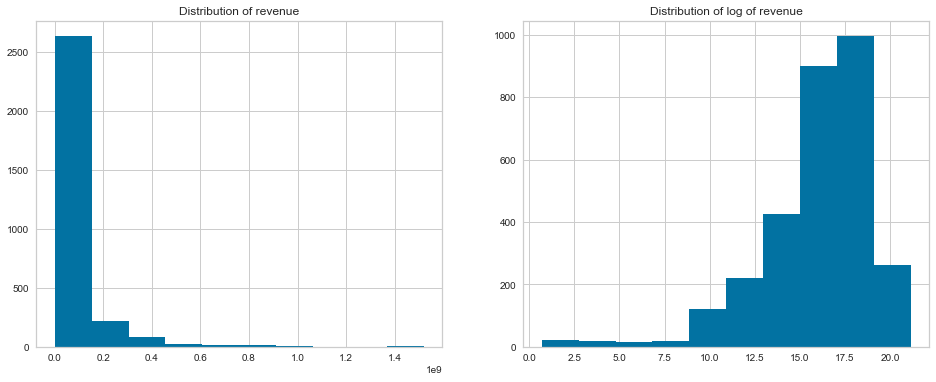

In [45]:
#Revenue
train_new=master[master['dataset']=='train']

fig, ax = plt.subplots(figsize = (16, 6))
plt.subplot(1, 2, 1)
plt.hist(train_new['revenue']);
plt.title('Distribution of revenue');
plt.subplot(1, 2, 2)
plt.hist(np.log1p(train_new['revenue']));
plt.title('Distribution of log of revenue');

As we can see revenue distribution has a high skewness. It is better to use np.log1p of revenue.

In [46]:
train_new['log_revenue'] = np.log1p(train_new['revenue'])

C:\Users\Brainz\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


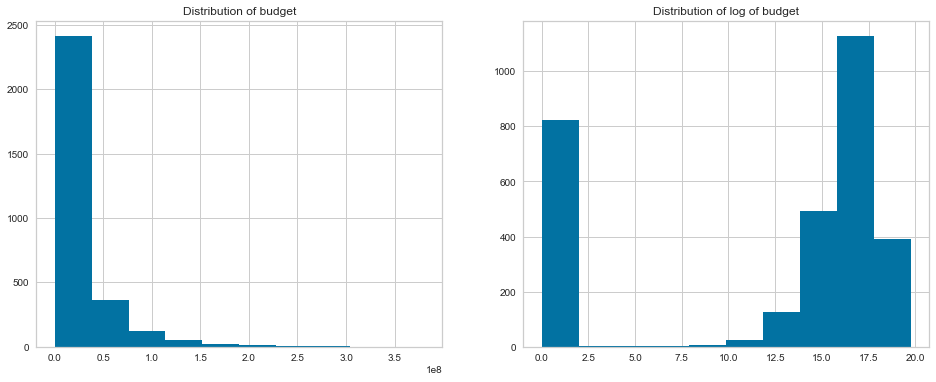

In [47]:
#Budget
fig, ax = plt.subplots(figsize = (16, 6))
plt.subplot(1, 2, 1)
plt.hist(train_new['budget']);
plt.title('Distribution of budget');
plt.subplot(1, 2, 2)
plt.hist(np.log1p(train_new['budget']));
plt.title('Distribution of log of budget');

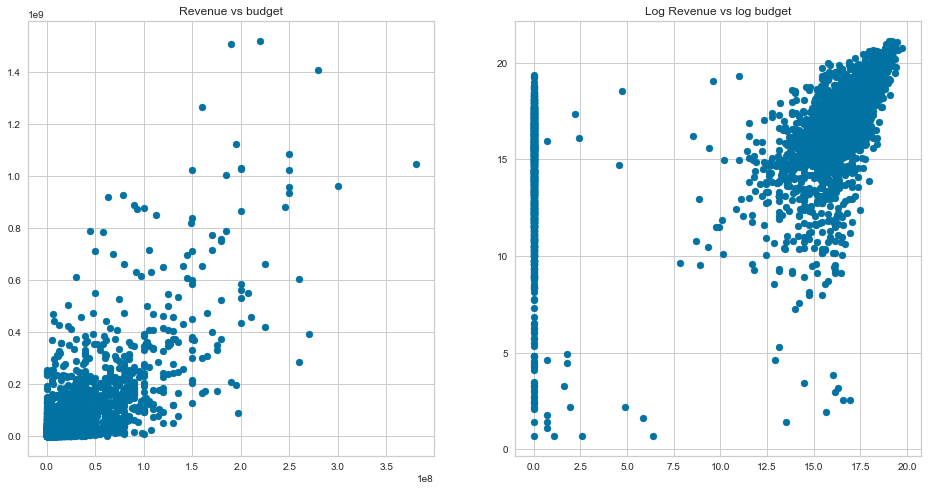

In [48]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train_new['budget'], train_new['revenue'])
plt.title('Revenue vs budget');
plt.subplot(1, 2, 2)
plt.scatter(np.log1p(train_new['budget']), train_new['log_revenue'])
plt.title('Log Revenue vs log budget');

We can see some clear trends that an increase in budget tend to lead to higher revenue.

In [49]:
#Homepage
train_new['homepage'].describe()

count                                   946
unique                                  941
top       http://www.transformersmovie.com/
freq                                      4
Name: homepage, dtype: object

In [50]:
train_new['has_homepage'] = train_new['homepage'].apply(lambda x: 1 if not pd.isnull(x) else 0)

C:\Users\Brainz\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


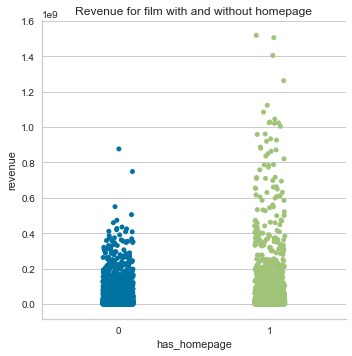

In [51]:
sns.catplot(x='has_homepage', y='revenue', data=train_new)
plt.title('Revenue for film with and without homepage')
plt.show()

Movies with homepages seem to be making more than movies without a homepage.

In [52]:
#original_language
train_new['original_language'].describe()

count     3000
unique      36
top         en
freq      2575
Name: original_language, dtype: object

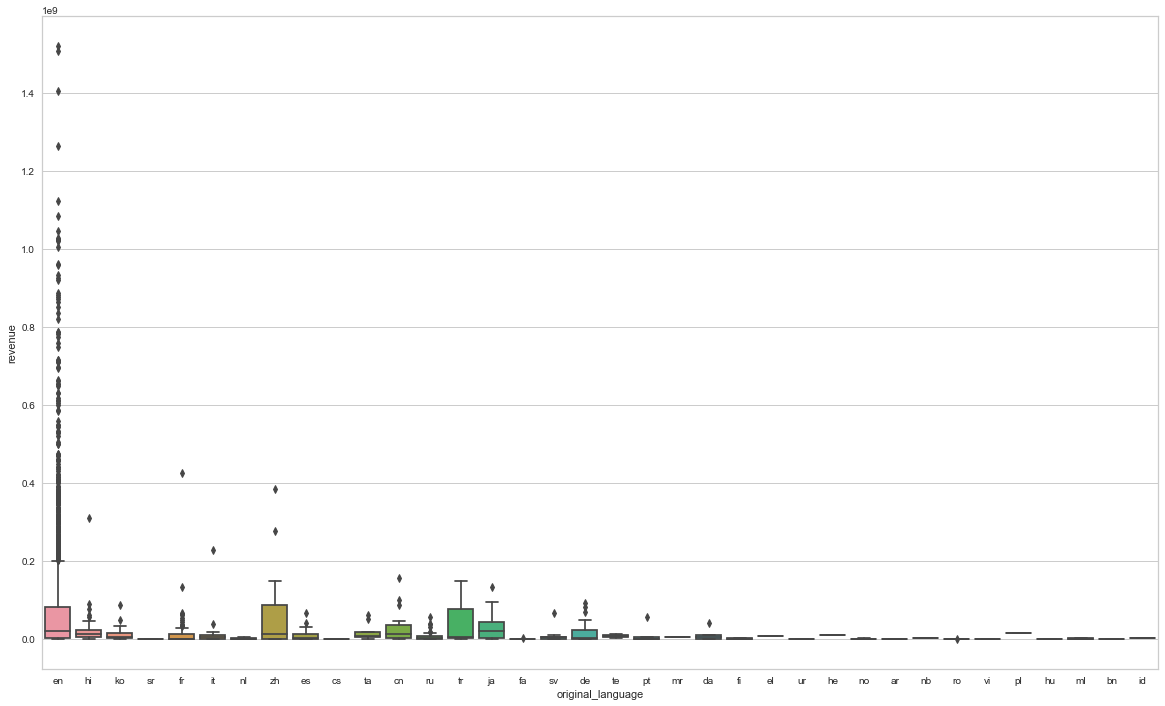

In [53]:
plt.figure(figsize=(20,12))
sns.boxplot(x='original_language', y='revenue', data=train_new)
plt.show()

As we know there are much more english films and they have a higher range of values. Films with the highest revenue are usually in English, but there are also high revenue films in other languages.

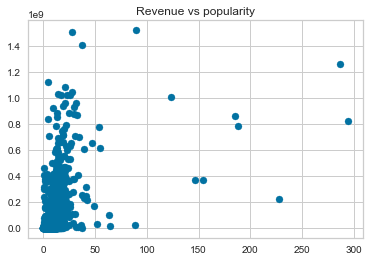

In [54]:
#popularity
plt.scatter(train_new['popularity'], train_new['revenue'])
plt.title('Revenue vs popularity')
plt.show()

We can see some clear trends that an increase in popularity tends to lead to higher revenue. 

In [55]:
#release_date
master.loc[master['release_date'].isnull() == True, 'release_date'] = '01/01/98'

#Since only last two digits of year are provided
master[['release_month','release_day','release_year']]=master['release_date'].str.split('/',expand=True).replace(np.nan, -1).astype(int)
# Some rows have 4 digits of year instead of 2, that's why (train['release_year'] < 100) 
master.loc[ (master['release_year'] <= 19) & (master['release_year'] < 100), "release_year"] += 2000
master.loc[ (master['release_year'] > 19)  & (master['release_year'] < 100), "release_year"] += 1900

releaseDate = pd.to_datetime(master['release_date']) 
master['release_dayofweek'] = releaseDate.dt.dayofweek
master['release_quarter'] = releaseDate.dt.quarter

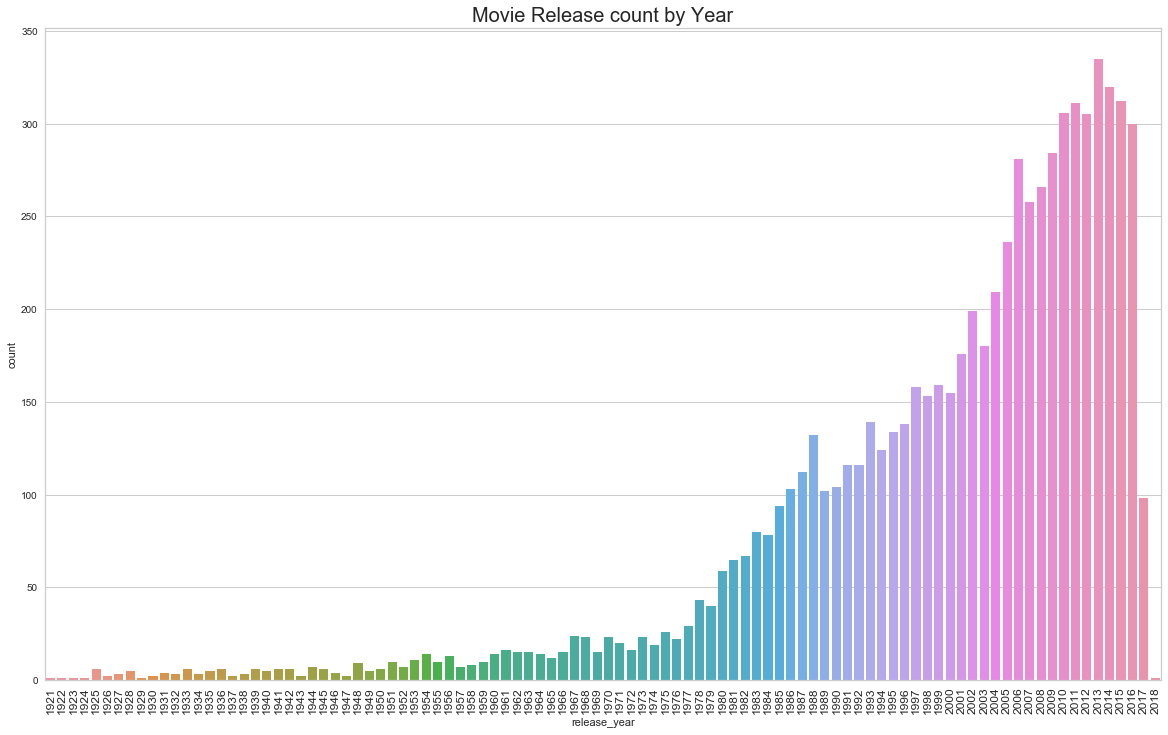

In [56]:
plt.figure(figsize=(20,12))
sns.countplot(master['release_year'].sort_values())
plt.title("Movie Release count by Year",fontsize=20)
plt.xticks(fontsize=12,rotation=90)
plt.show()

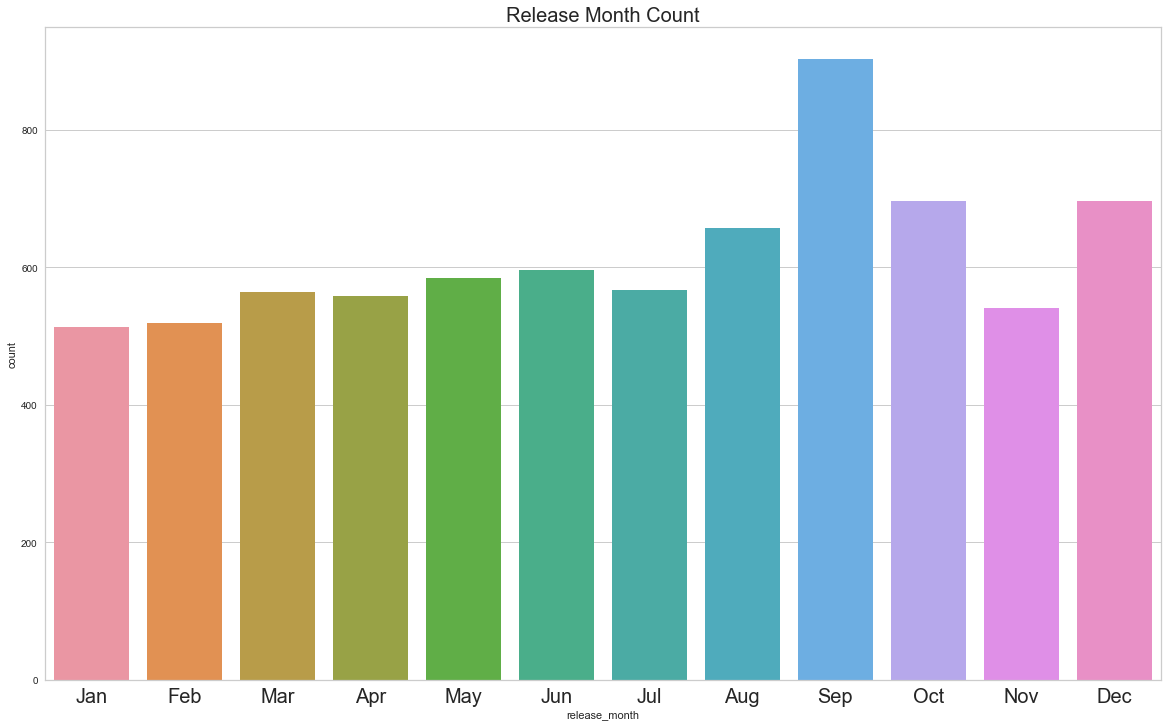

In [57]:
plt.figure(figsize=(20,12))
sns.countplot(master['release_month'].sort_values())
plt.title("Release Month Count",fontsize=20)
loc, labels = plt.xticks()
loc, labels = loc, ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
plt.xticks(loc, labels,fontsize=20)
plt.show()

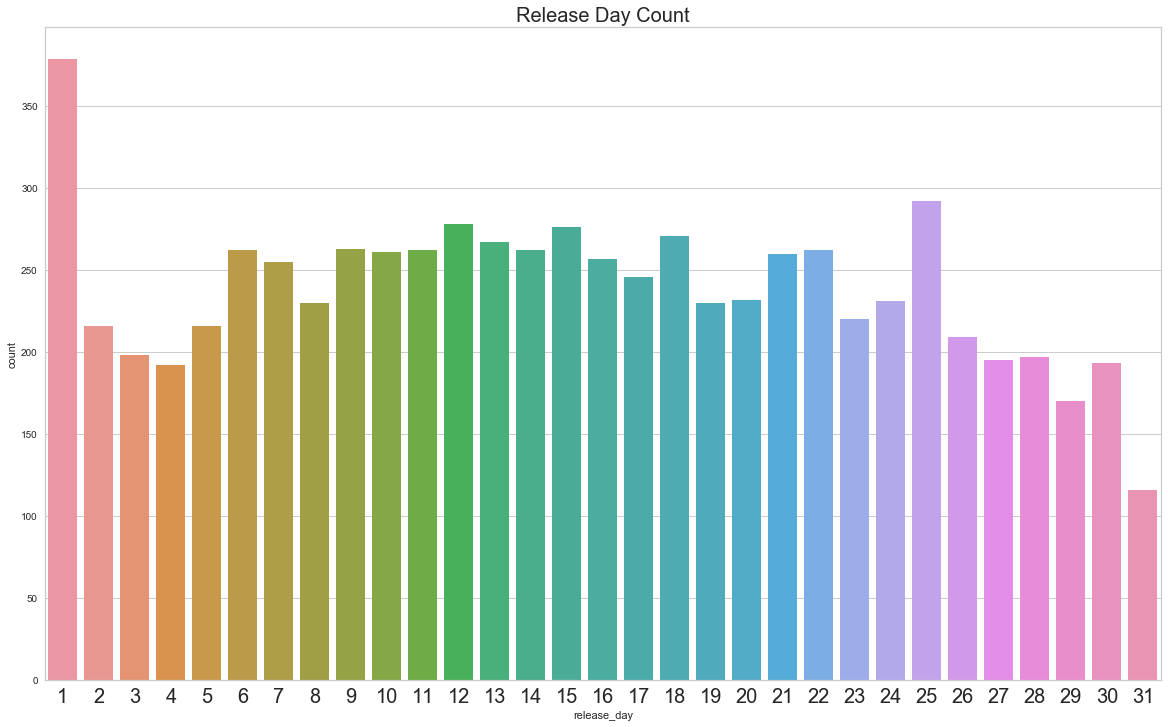

In [58]:
plt.figure(figsize=(20,12))
sns.countplot(master['release_day'].sort_values())
plt.title("Release Day Count",fontsize=20)
plt.xticks(fontsize=20)
plt.show()

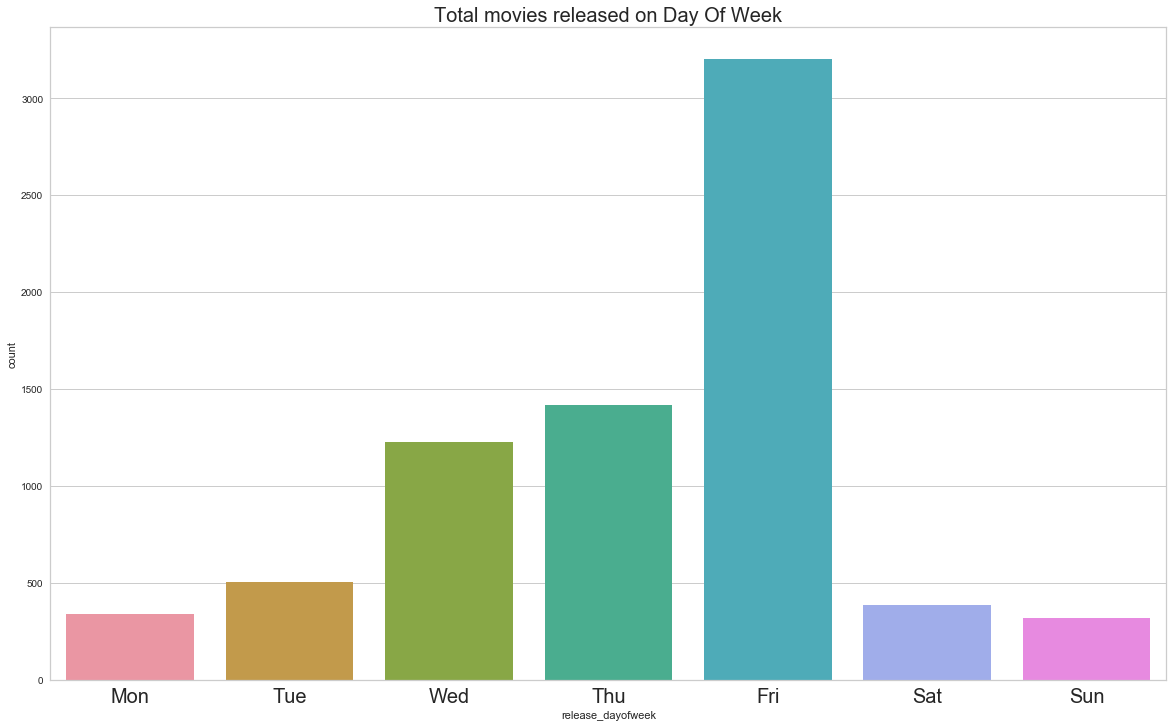

In [59]:
plt.figure(figsize=(20,12))
sns.countplot(master['release_dayofweek'].sort_values())
plt.title("Total movies released on Day Of Week",fontsize=20)
loc, labels = plt.xticks()
loc, labels = loc, ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
plt.xticks(loc, labels,fontsize=20)
plt.show()

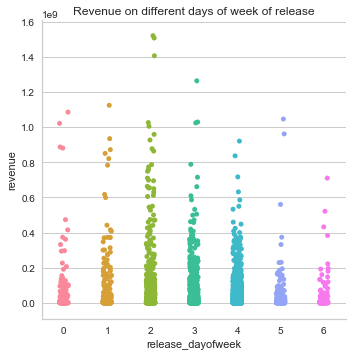

In [60]:
train_new=master[master['dataset']=='train']
sns.catplot(x='release_dayofweek', y='revenue', data=train_new);
plt.title('Revenue on different days of week of release');

Films released on Wednesdays and on Thursdays tend to have a higher revenue.

Text(0.5, 1.0, 'Average revenue per year')

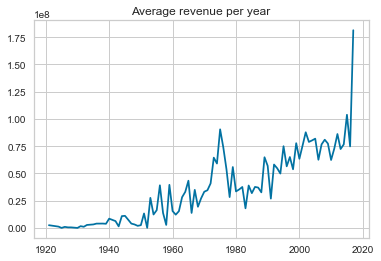

In [61]:
d2 = train_new.groupby(['release_year'])['revenue'].mean()
_=plt.plot(d2)
plt.title("Average revenue per year")

In [62]:
#create dummies for dayofweek
master=pd.get_dummies(master, columns=['release_dayofweek'])

We can see that number of films and total revenue are growing, which is to be expected. But there were some years in the past with a high number of successful films, which brought high revenue.

Text(0.5, 1.0, 'runtime vs popularity')

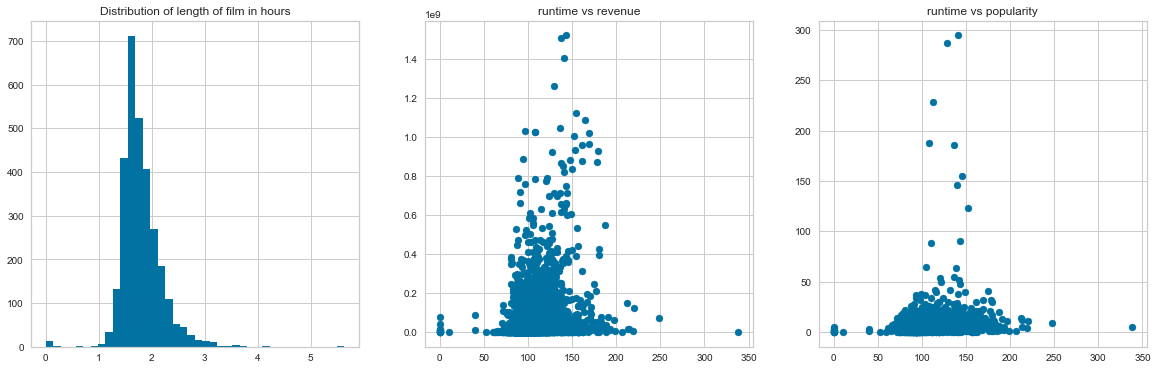

In [63]:
#runtime
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.hist(train_new['runtime'].fillna(0) / 60, bins=40);
plt.title('Distribution of length of film in hours');
plt.subplot(1, 3, 2)
plt.scatter(train_new['runtime'].fillna(0), train_new['revenue'])
plt.title('runtime vs revenue');
plt.subplot(1, 3, 3)
plt.scatter(train_new['runtime'].fillna(0), train_new['popularity'])
plt.title('runtime vs popularity')

It seems that most of the films are 1.5-2 hour long and films with the highest revenue are also in this range

In [64]:
#status
train_new['status'].describe()

count         3000
unique           2
top       Released
freq          2996
Name: status, dtype: object

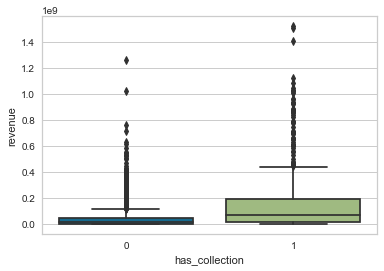

In [65]:
#collections
sns.boxplot(x='has_collection', y='revenue', data=train_new)
plt.show()

Films, which are part of a collection usually have higher revenues. I suppose such films have a bigger fan base thanks to previous films.

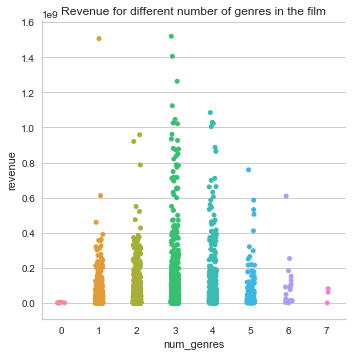

In [66]:
#genres
sns.catplot(x='num_genres', y='revenue', data=train_new);
plt.title('Revenue for different number of genres in the film')
plt.show()

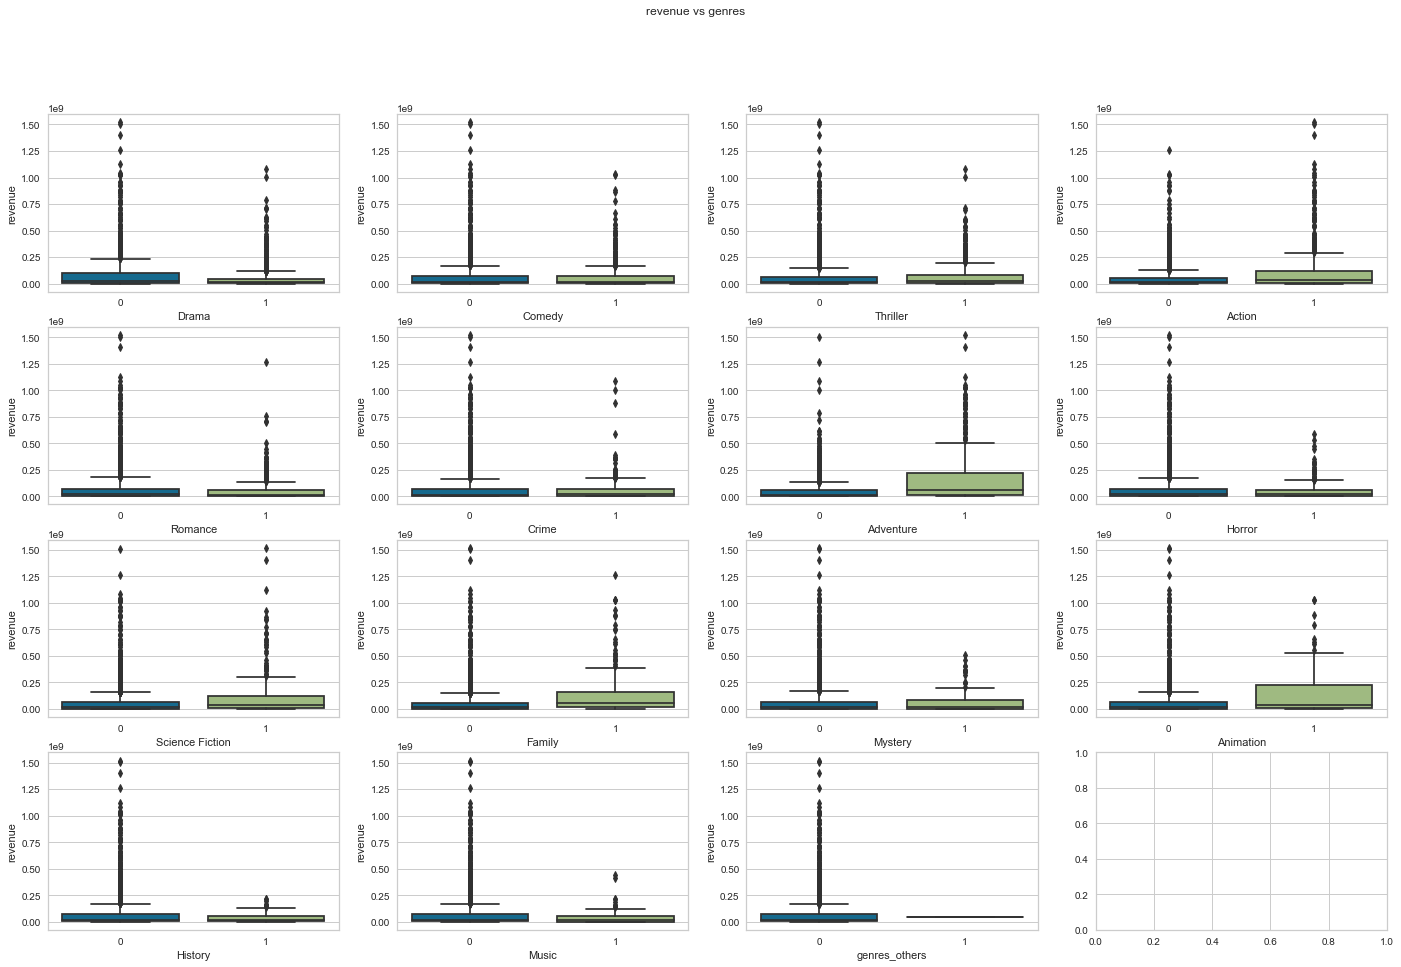

In [67]:
f, axes = plt.subplots(4, 4, figsize=(24, 15))
plt.suptitle('revenue vs genres')
for i, e in enumerate([col for col in ['Drama','Comedy','Thriller','Action','Romance','Crime','Adventure','Horror','Science Fiction','Family','Mystery','Animation','History', 'Music','genres_others']]):
    sns.boxplot(x=e, y='revenue', data=train_new, ax=axes[i // 4][i % 4]);

Some genres tend to have less revenue, some tend to have higher.

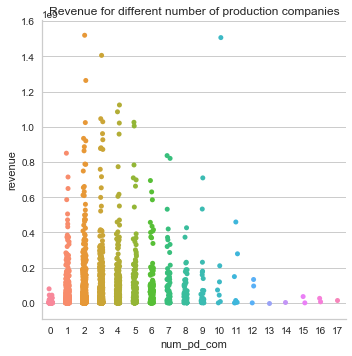

In [68]:
#production companies
sns.catplot(x='num_pd_com', y='revenue', data=train_new);
plt.title('Revenue for different number of production companies')
plt.show()

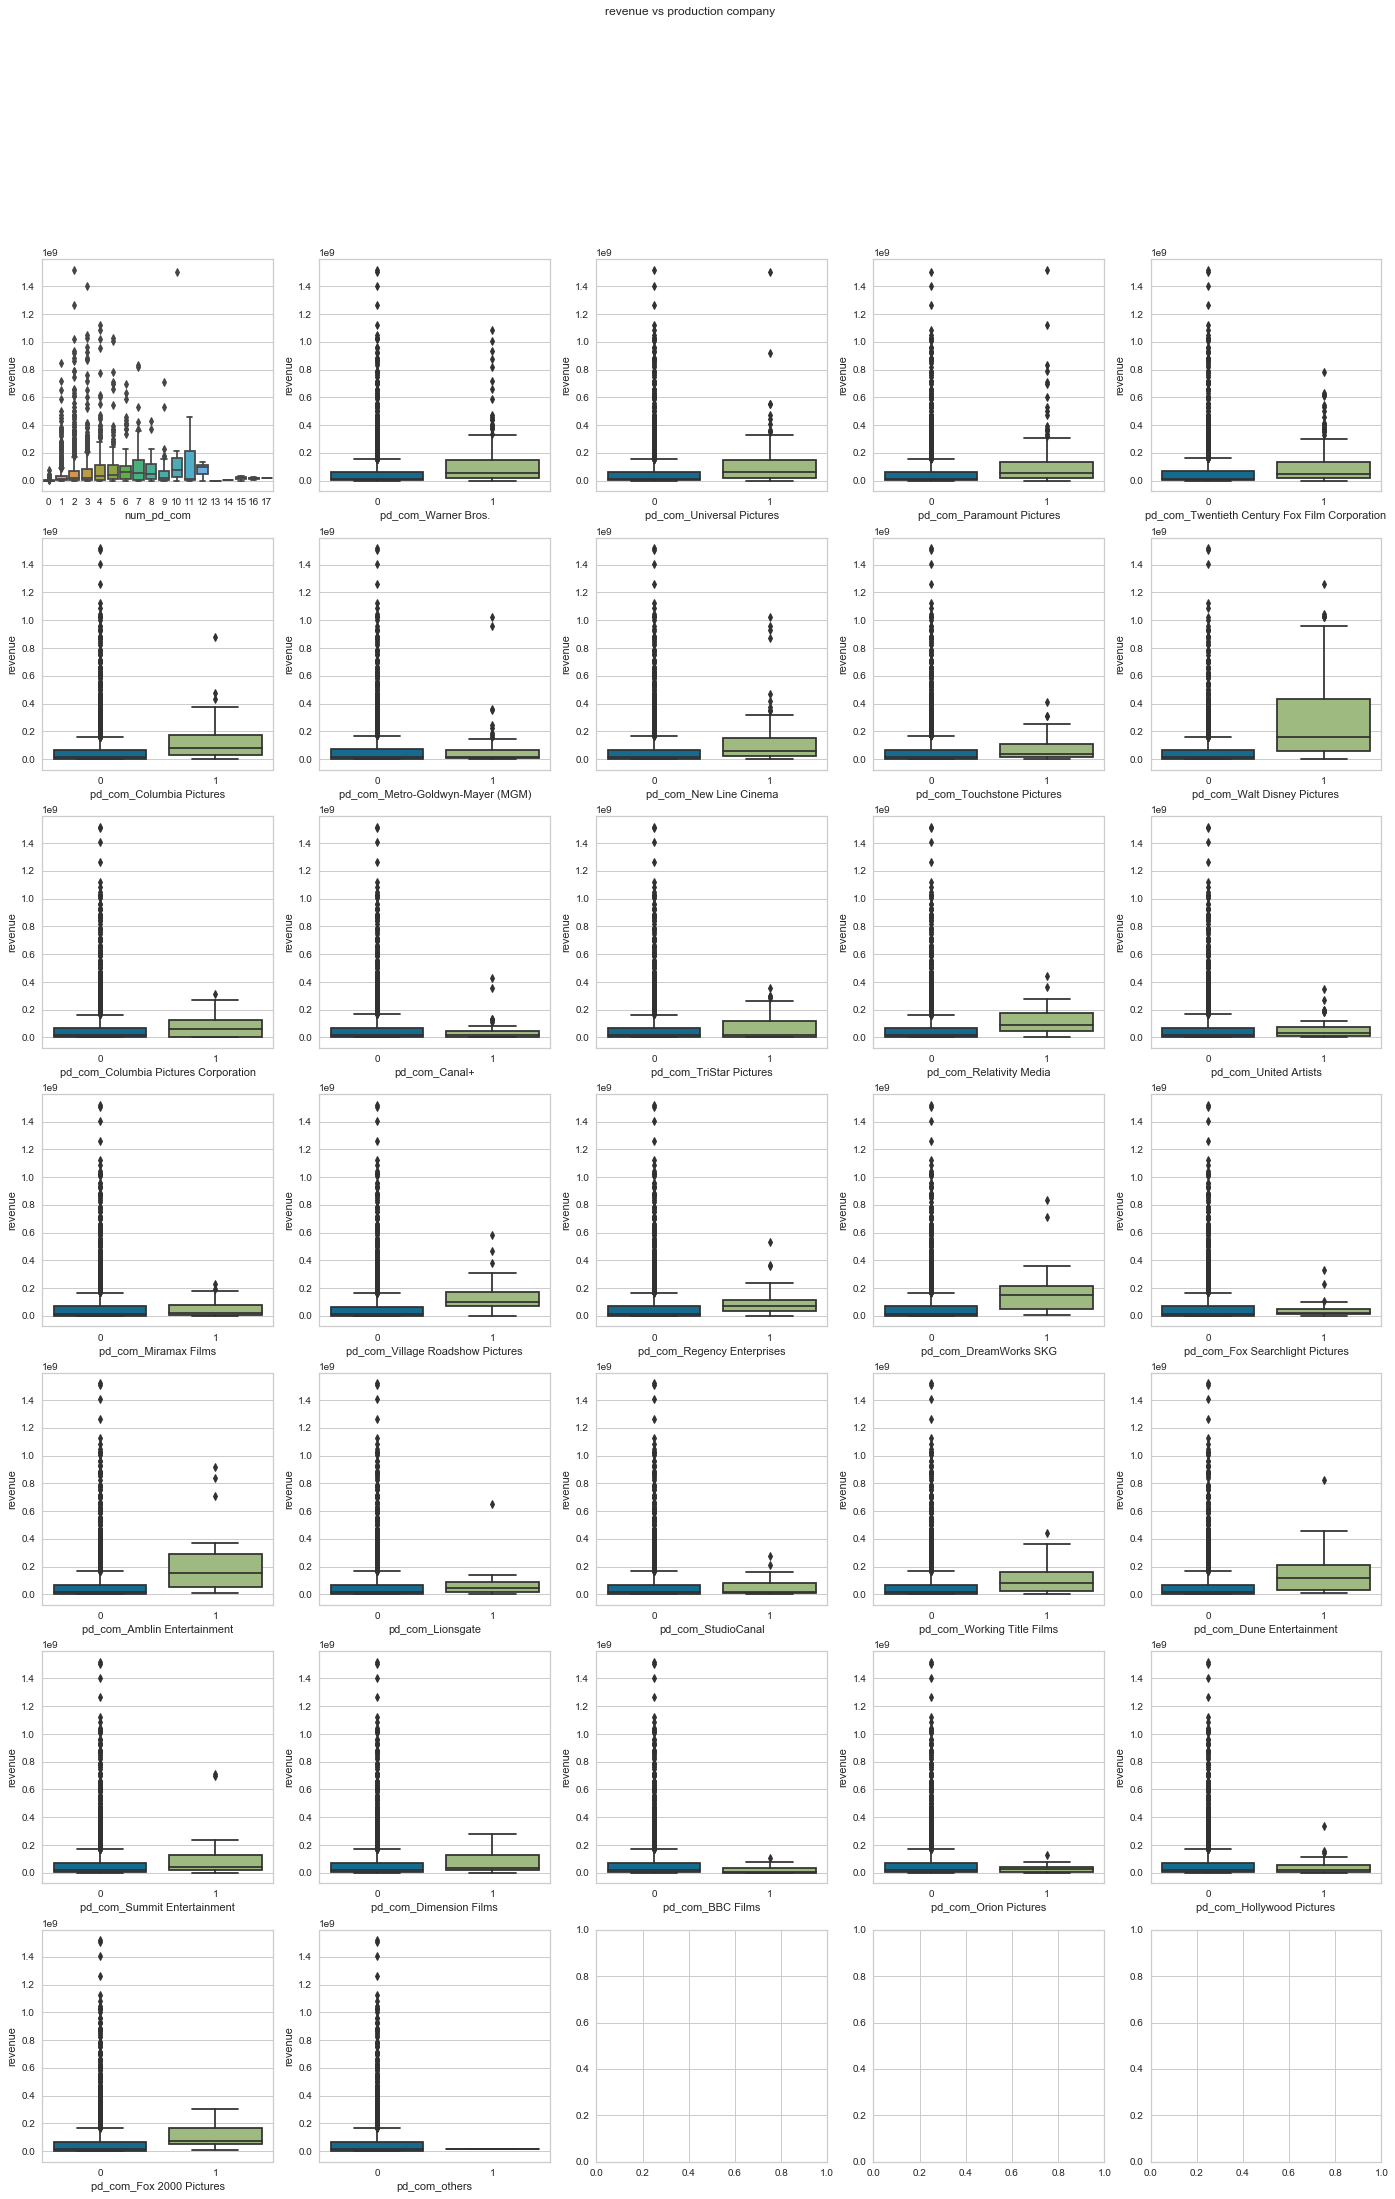

In [69]:
f, axes = plt.subplots(7, 5, figsize=(24, 35))
plt.suptitle('revenue vs production company')
for i, e in enumerate([col for col in train_new.columns if 'pd_com' in col]):
    sns.boxplot(x=e, y='revenue', data=train_new, ax=axes[i // 5][i % 5]);

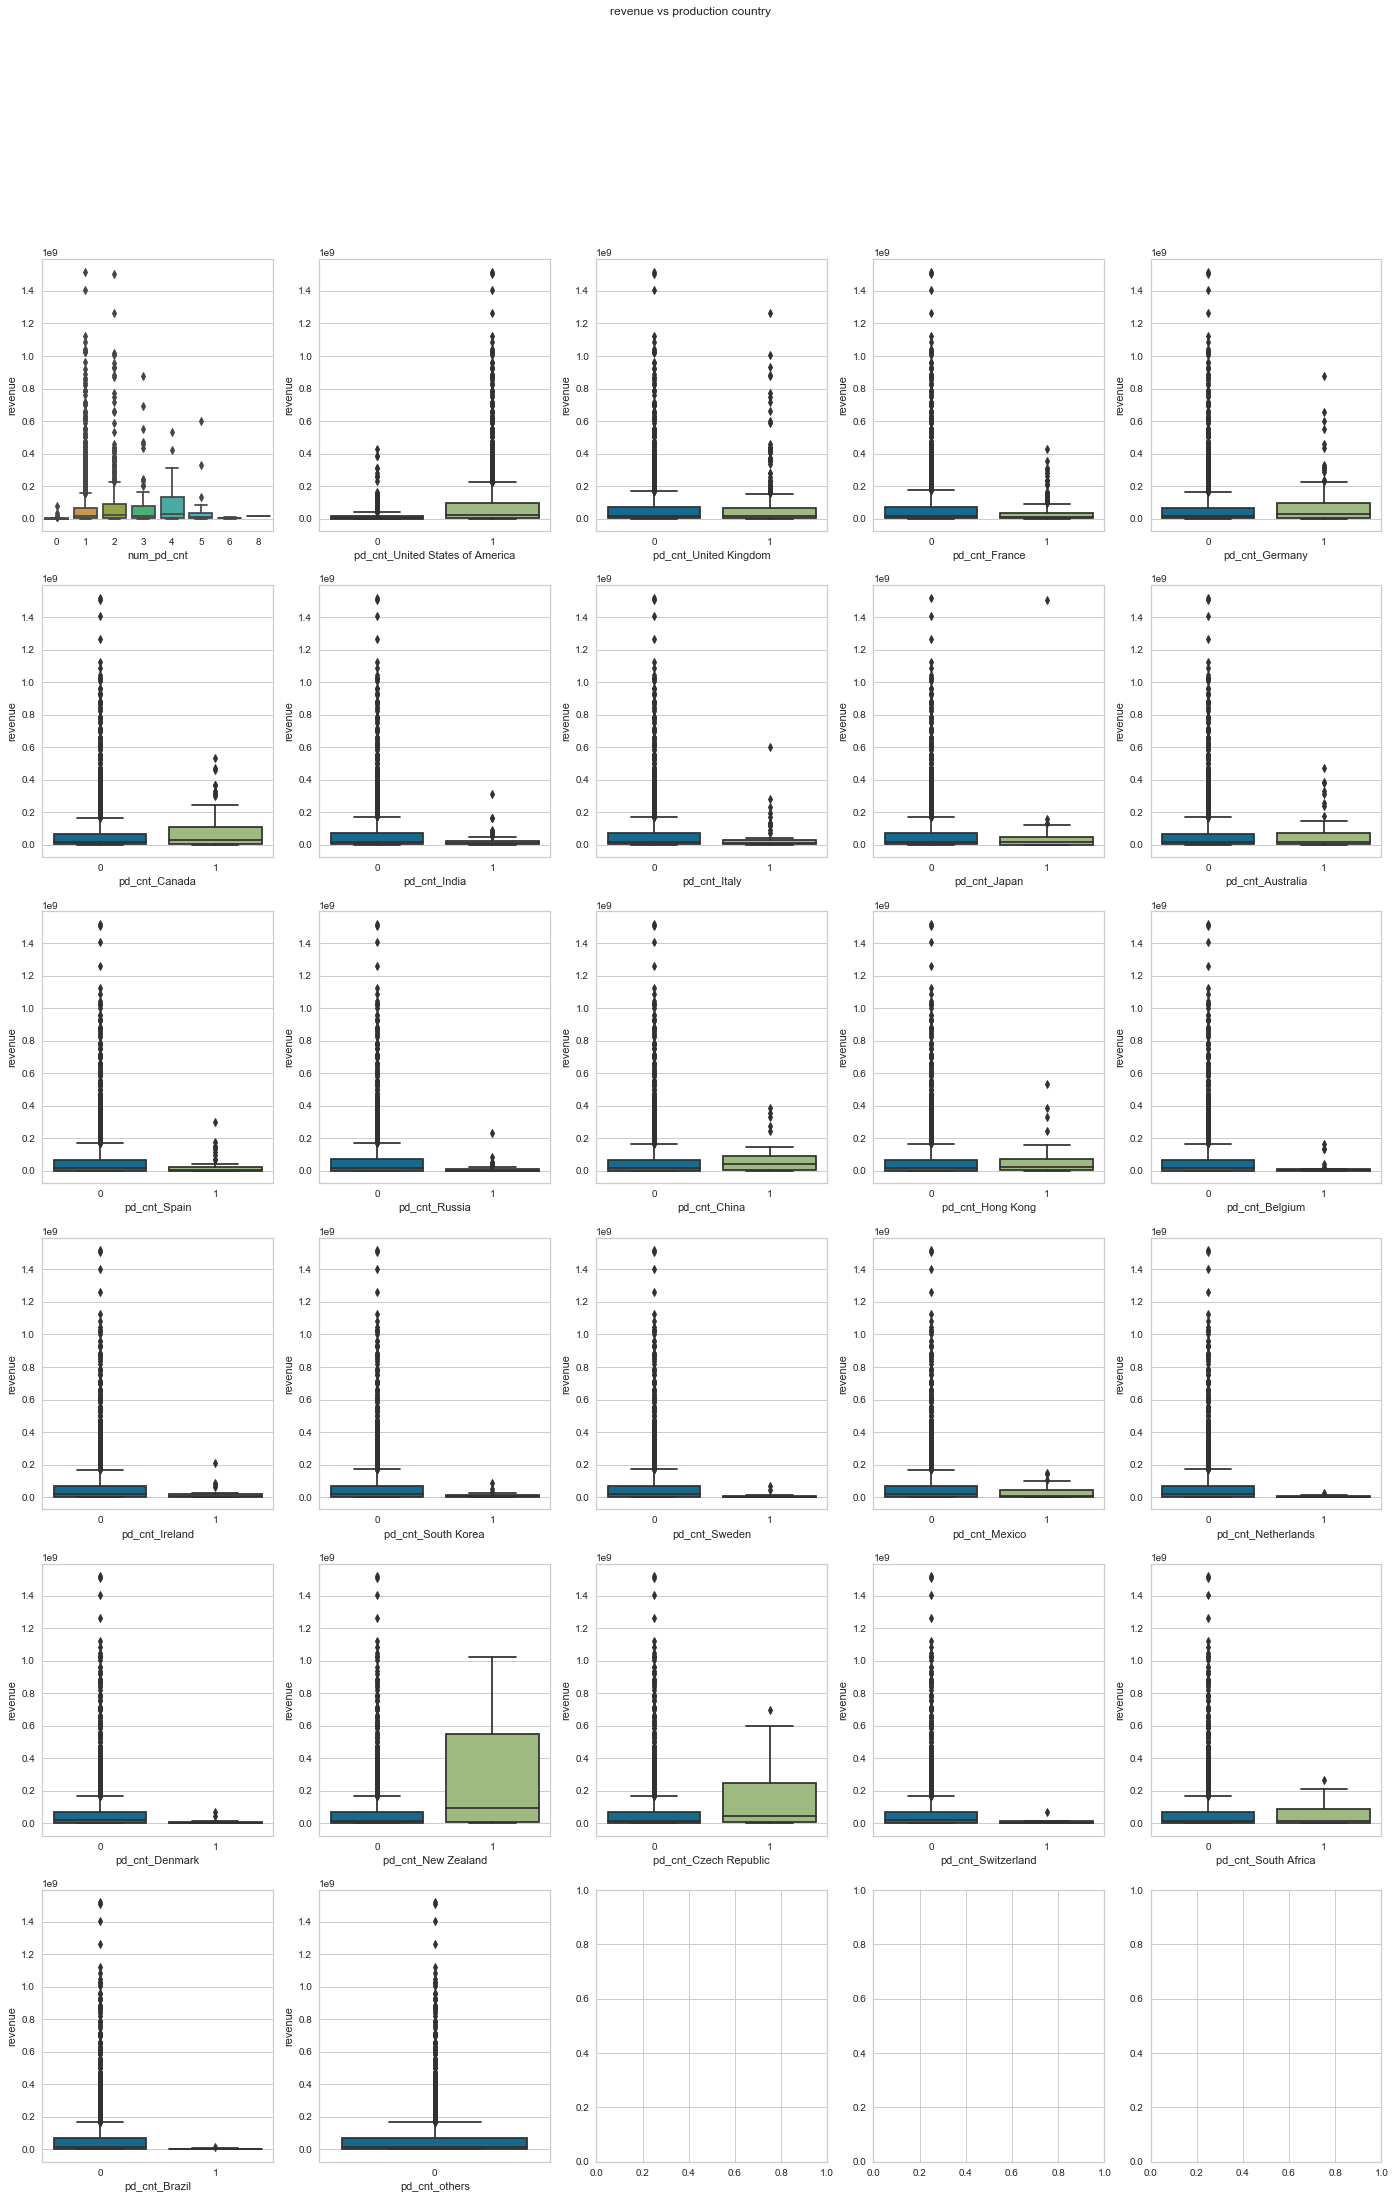

In [70]:
#production countries
f, axes = plt.subplots(6, 5, figsize=(24, 35))
plt.suptitle('revenue vs production country')
for i, e in enumerate([col for col in train_new.columns if 'pd_cnt' in col]):
    sns.boxplot(x=e, y='revenue', data=train_new, ax=axes[i // 5][i % 5]);

Text(0.5, 1.0, 'Number of cast members vs revenue')

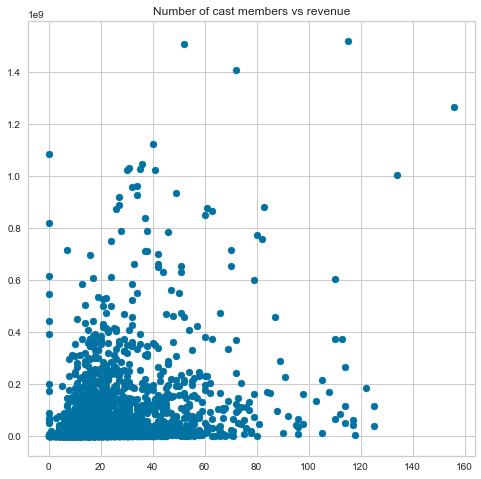

In [71]:
#cast
plt.figure(figsize=(8, 8))
plt.scatter(train_new['num_cast'], train_new['revenue'])
plt.title('Number of cast members vs revenue')

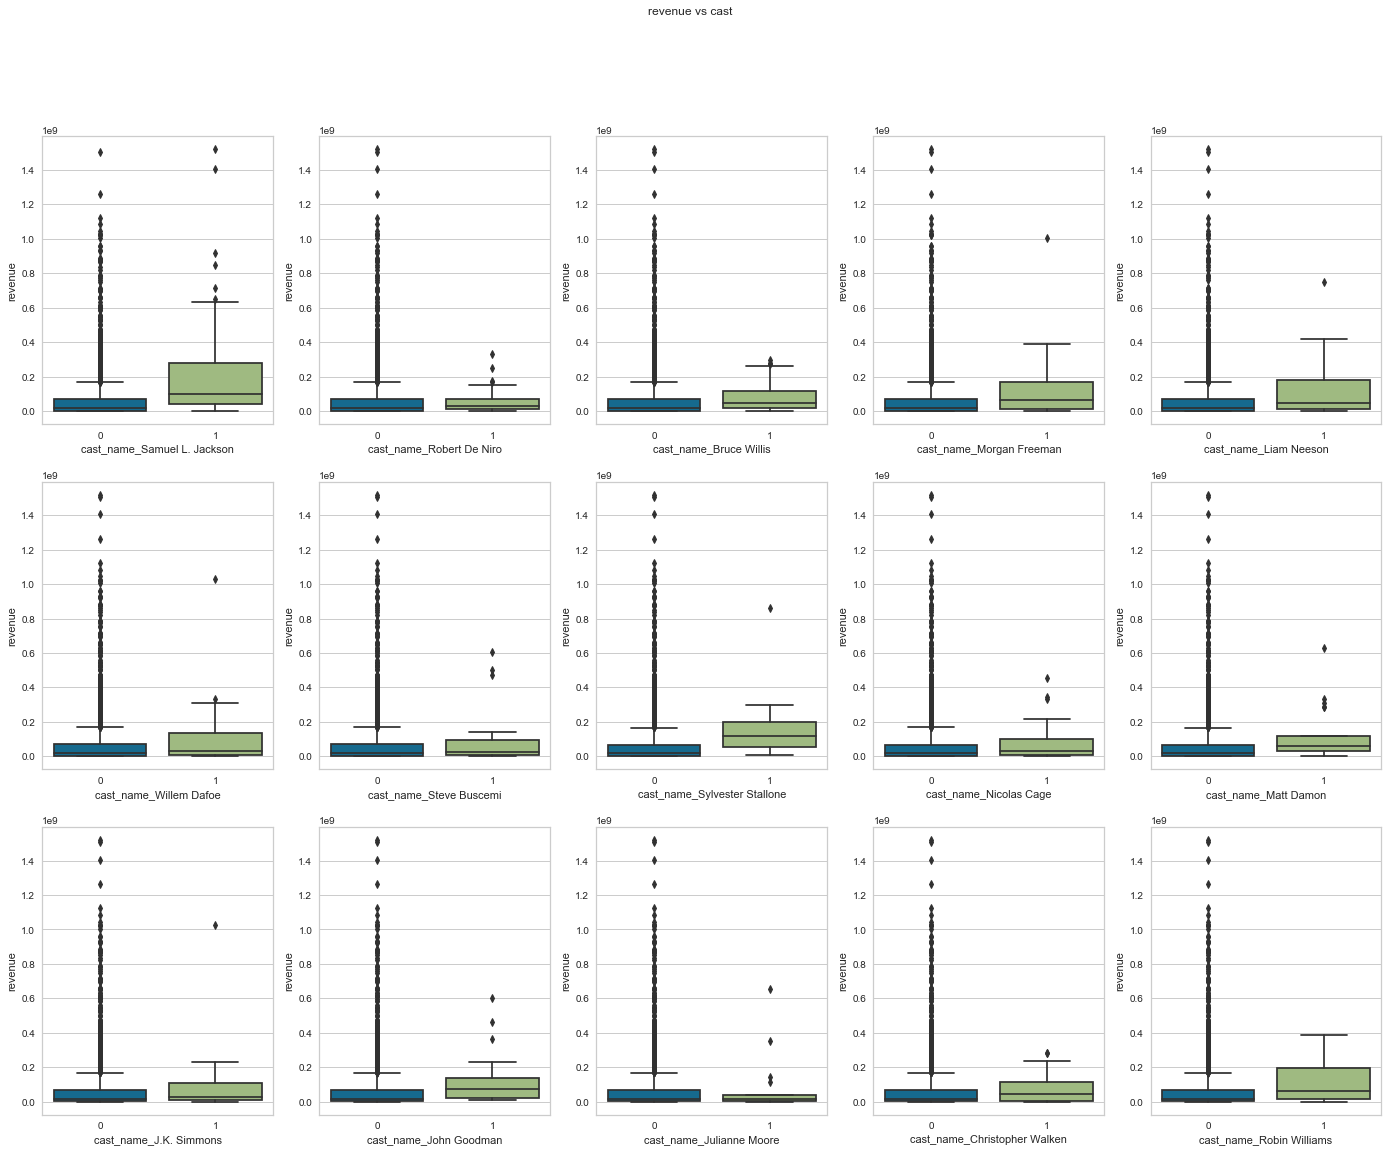

In [72]:
f, axes = plt.subplots(3, 5, figsize=(24, 18))
plt.suptitle('revenue vs cast')
for i, e in enumerate([col for col in train_new.columns if 'cast_name' in col]):
    sns.boxplot(x=e, y='revenue', data=train_new, ax=axes[i // 5][i % 5]);

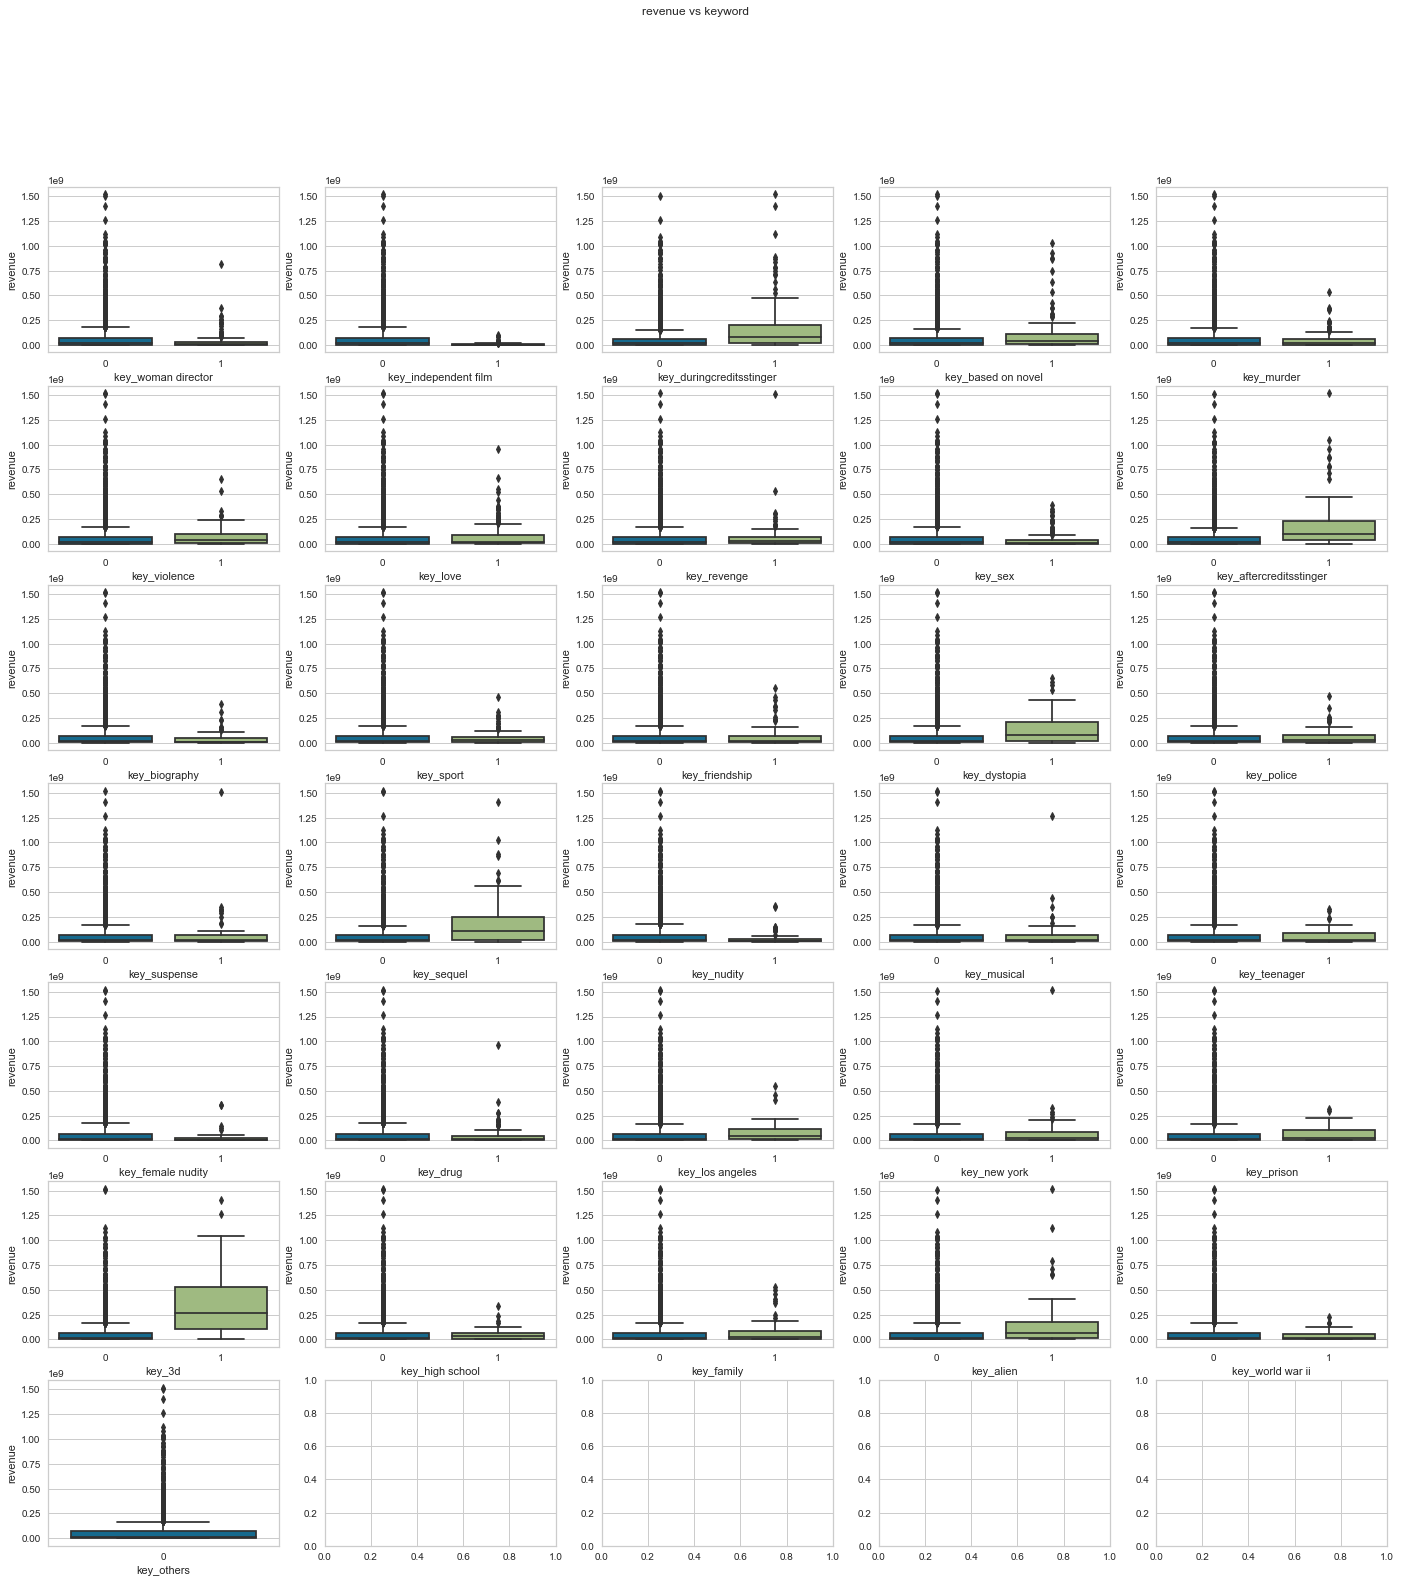

In [73]:
#Keywords
f, axes = plt.subplots(7, 5, figsize=(24, 25))
plt.suptitle('revenue vs keyword')
for i, e in enumerate([col for col in train_new.columns if 'key_' in col]):
    sns.boxplot(x=e, y='revenue', data=train_new, ax=axes[i // 5][i % 5]);

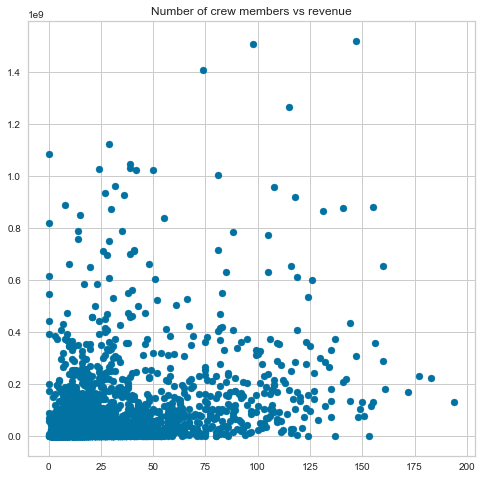

In [74]:
#crew
plt.figure(figsize=(8, 8))
plt.scatter(train_new['num_crew'], train_new['revenue'])
_=plt.title('Number of crew members vs revenue')

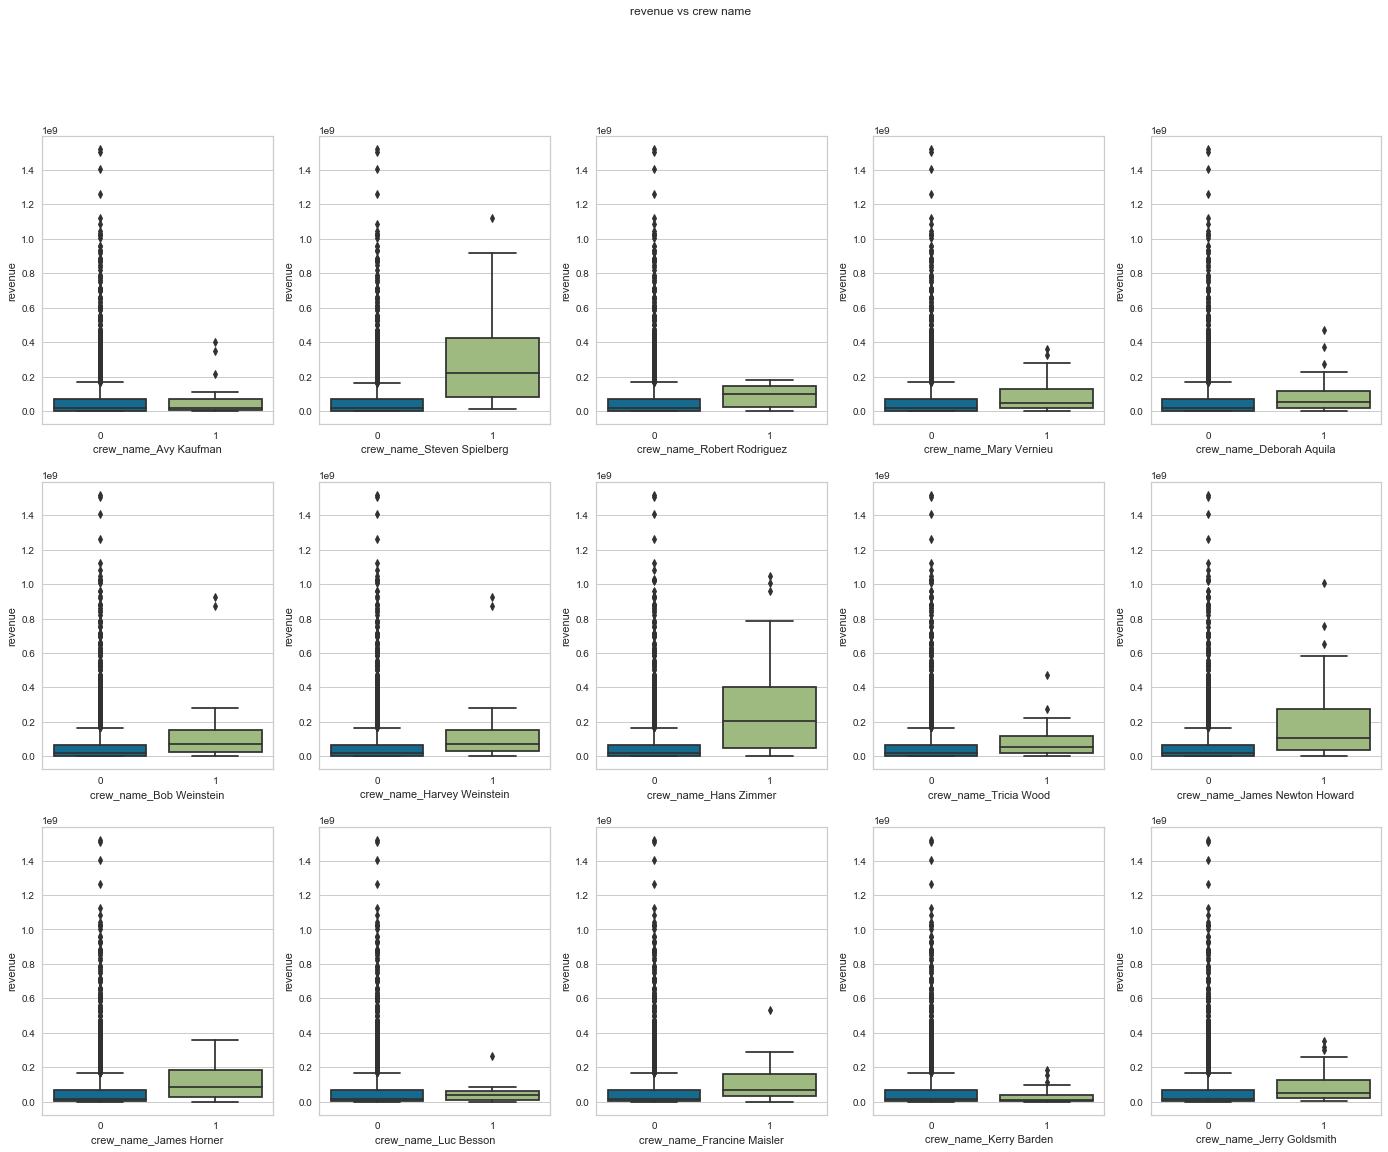

In [75]:
f, axes = plt.subplots(3, 5, figsize=(24, 18))
plt.suptitle('revenue vs crew name')
for i, e in enumerate([col for col in train_new.columns if 'crew_name_' in col]):
    sns.boxplot(x=e, y='revenue', data=train_new, ax=axes[i // 5][i % 5]);

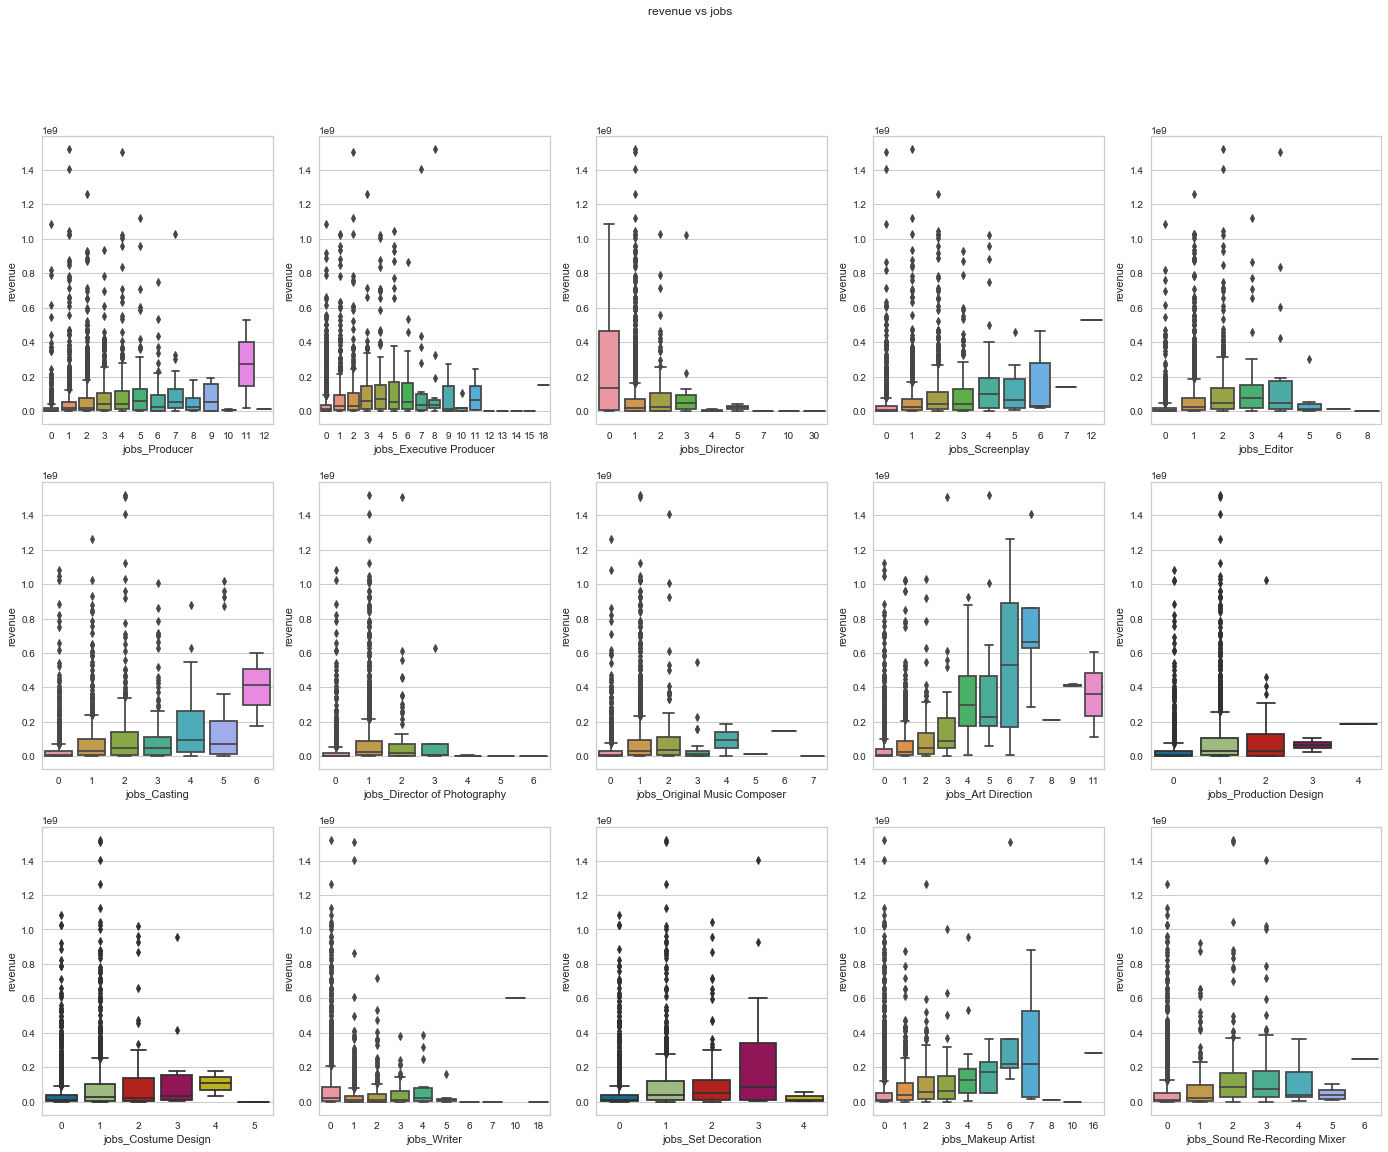

In [76]:
f, axes = plt.subplots(3, 5, figsize=(24, 18))
plt.suptitle('revenue vs jobs')
for i, e in enumerate([col for col in train_new.columns if 'jobs_' in col]):
    sns.boxplot(x=e, y='revenue', data=train_new, ax=axes[i // 5][i % 5]);

In [77]:
#drop columns
master = master.drop(['homepage', 'imdb_id', 'poster_path', 'release_date', 'status','release_month','release_day','release_year','release_quarter','original_language','original_title','overview','tagline','title','collection_name'], axis=1)
master = master.set_index('id')

In [78]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [79]:
master.isnull().values.any()

True

In [80]:
master.isnull().sum().sum()

4404

# Machine Learning

In [81]:
train_fin=master[master['dataset']=='train']
train_fin = train_fin.drop(['dataset'], axis=1)

df_X_train=train_fin.loc[:, train_fin.columns != 'revenue']
df_y_train=np.log1p(train_fin['revenue'])

scaler = StandardScaler()
scaler.fit(df_X_train)
Xs = scaler.transform(df_X_train)

imputer = KNNImputer(n_neighbors=3)
X=imputer.fit_transform(Xs)
y=df_y_train.values

In [82]:
feature_names=df_X_train.columns

We will split the training set into a 80-20 train and test set. 

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Lets run Linear regression in training purpose and plot some predicted vs actual data.

In [84]:
#Linear Regression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred=regressor.predict(X_test)
#y_pred[y_pred<0]=0

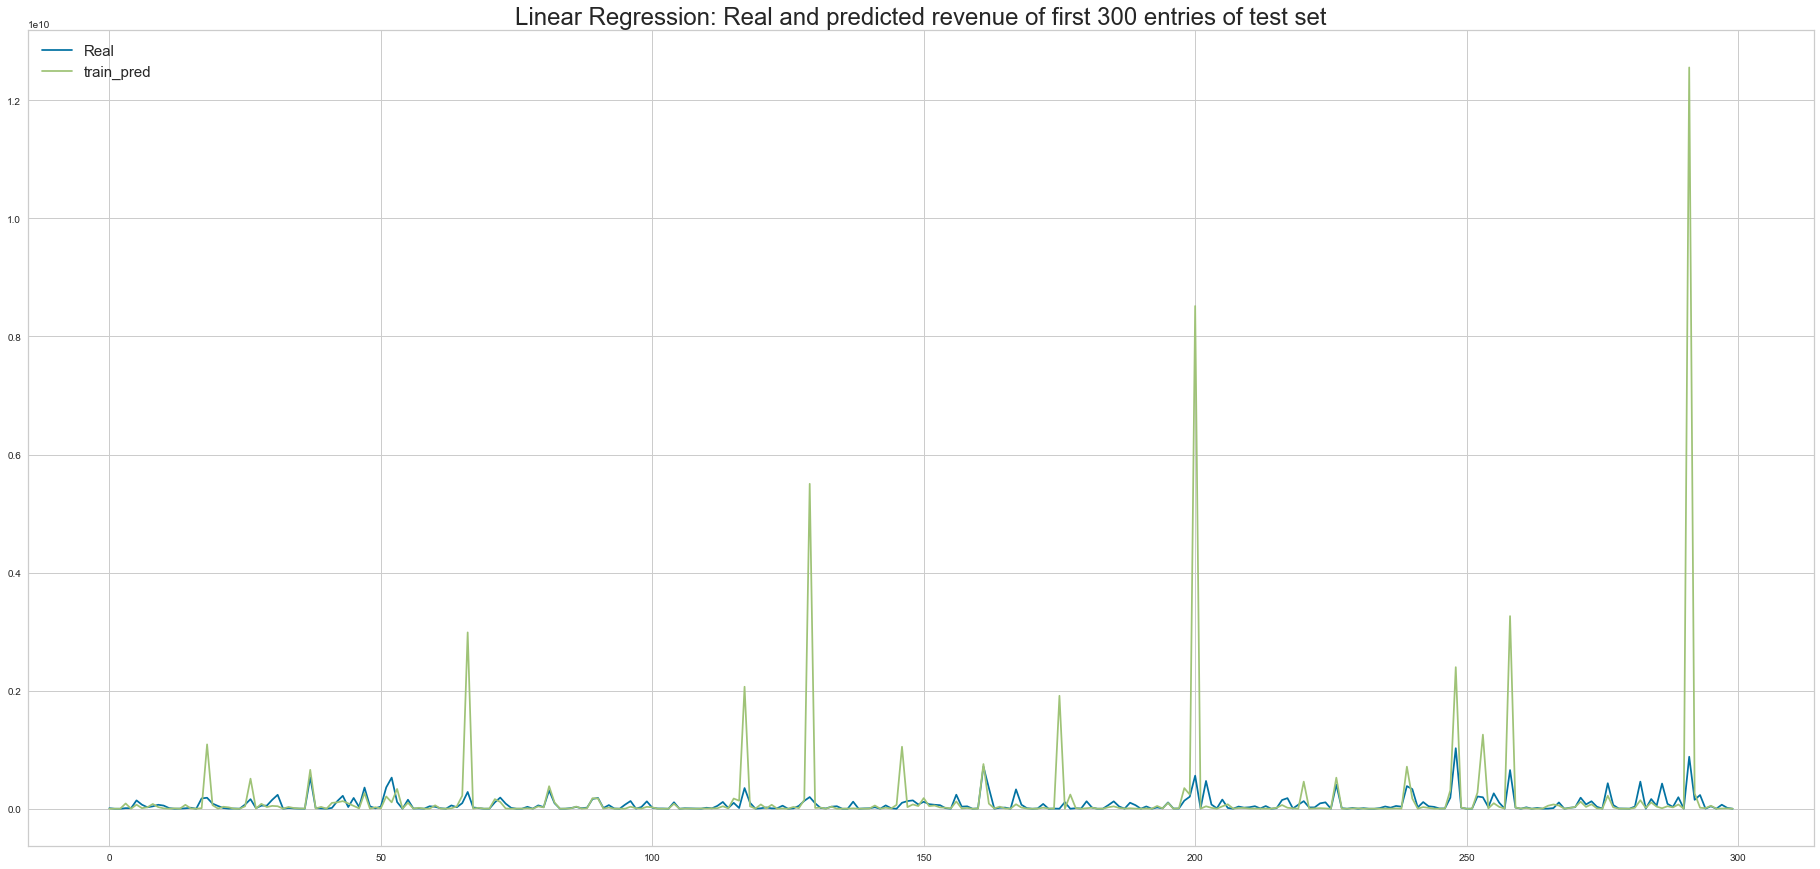

In [127]:
plt.figure(figsize=(32,15))
plt.plot(np.expm1(y_test).reset_index().revenue[:300],label="Real")
plt.plot(np.expm1(y_pred)[:300],label="train_pred")
plt.legend(fontsize=15)
plt.title("Linear Regression: Real and predicted revenue of first 300 entries of test set",fontsize=24)
plt.show()

In [86]:
#Linear Regression metrics
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('Root Mean Squared Log Error:',np.sqrt(mean_squared_log_error( y_test, y_pred )))

Mean Absolute Error: 1.6529731752547987
Mean Squared Error: 5.409314039772738
Root Mean Squared Error: 2.3257932065797977
Root Mean Squared Log Error: 0.2011801828004976


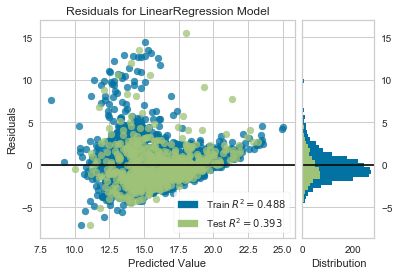

In [87]:
#Linear Regression residuals plot
visualizer = ResidualsPlot(regressor)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

In [88]:
#Ridge regression
clf = Ridge(alpha=.001)
clf.fit(X, y)
y_pred_clf=clf.predict(X_test)
#y_pred_clf[y_pred_clf<0]=0

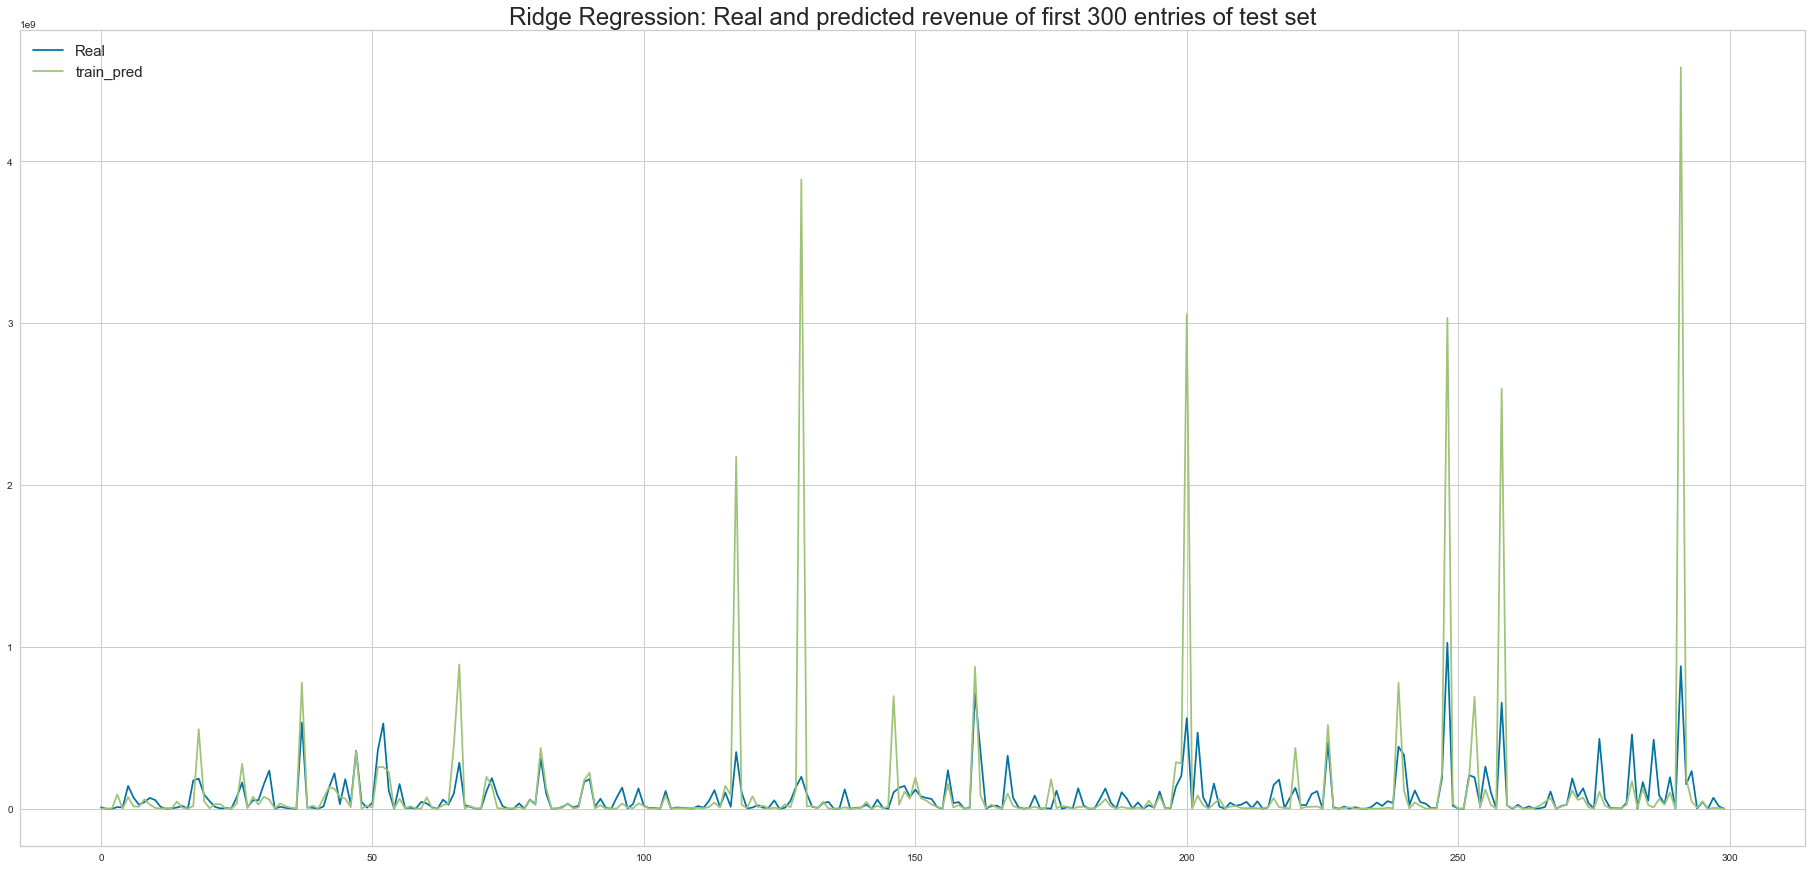

In [126]:
plt.figure(figsize=(32,15))
plt.plot(np.expm1(y_test).reset_index().revenue[:300],label="Real")
plt.plot(np.expm1(y_pred_clf)[:300],label="train_pred")
plt.legend(fontsize=15)
plt.title("Ridge Regression: Real and predicted revenue of first 300 entries of test set",fontsize=24)
plt.show()

In [89]:
#Ridge Regression metrics
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_clf))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_clf))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_clf)))
print('Root Mean Squared Log Error:', np.sqrt(mean_squared_log_error( y_test, y_pred_clf )))

Mean Absolute Error: 1.5057761066285862
Mean Squared Error: 4.579507177886461
Root Mean Squared Error: 2.1399783124804
Root Mean Squared Log Error: 0.19209503363002162


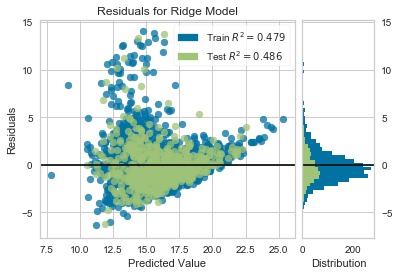

In [90]:
#Ridge Regression residuals plot
visualizer = ResidualsPlot(clf)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

## XGBOOST

We need to create the XGBoost matrices that will be used to train the model using XGBoost. 
I defined parameters for xgboost model to see how it works. 

In [91]:
X_train, X_test, y_train, y_test = train_test_split(df_X_train, df_y_train, test_size=0.2, random_state=42)
# read in data
dtrain = xgb.DMatrix(X_train, label=y_train,feature_names=feature_names)
dtest = xgb.DMatrix(X_test, label=y_test,feature_names=feature_names)
watchlist = [(dtrain, 'train'), (dtest,'test')]
eval_set = [(X_test, y_test)]
# specify parameters via map
param = {'min_child_weight': 1, 'eta': 0.5, 'colsample_bytree': 0.9, 'max_depth': 6,'subsample': 0.9, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
'eval_metric': 'rmse', 'objective': 'reg:linear'}
bst = xgb.train(param, dtrain, 10)
# make prediction
preds = bst.predict(dtest)

C:\Users\Brainz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


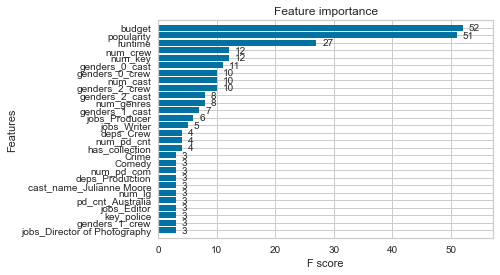

In [92]:
_=xgb.plot_importance(bst, max_num_features=28, height=0.8)

Now we play with the different parameters of the XGBoost algorithm to tweak the model's outcome and find best model.

In [93]:
md = [4,5,6]
lr = [0.01,0.05,0.1,0.3]
mcw = [1,5,20,25,30]
for m in md:
    for l in lr:
        for n in mcw:
            pd.set_option('display.float_format', lambda x: '%.3f' % x)
            print(m,l,n)
            t0 = datetime.now()
            xgb_pars = {'min_child_weight': n, 'eta': l, 'colsample_bytree': 0.9, 
                       'max_depth': m,'subsample': 0.9, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
           'eval_metric': 'rmse', 'objective': 'reg:linear'}
            model = xgb.train(xgb_pars, dtrain, 500, watchlist, early_stopping_rounds=50,
                 maximize=False, verbose_eval=0)


4 0.01 1
4 0.01 5
4 0.01 20
4 0.01 25
4 0.01 30
4 0.05 1
4 0.05 5
4 0.05 20
4 0.05 25
4 0.05 30
4 0.1 1
4 0.1 5
4 0.1 20
4 0.1 25
4 0.1 30
4 0.3 1
4 0.3 5
4 0.3 20
4 0.3 25
4 0.3 30
5 0.01 1
5 0.01 5
5 0.01 20
5 0.01 25
5 0.01 30
5 0.05 1
5 0.05 5
5 0.05 20
5 0.05 25
5 0.05 30
5 0.1 1
5 0.1 5
5 0.1 20
5 0.1 25
5 0.1 30
5 0.3 1
5 0.3 5
5 0.3 20
5 0.3 25
5 0.3 30
6 0.01 1
6 0.01 5
6 0.01 20
6 0.01 25
6 0.01 30
6 0.05 1
6 0.05 5
6 0.05 20
6 0.05 25
6 0.05 30
6 0.1 1
6 0.1 5
6 0.1 20
6 0.1 25
6 0.1 30
6 0.3 1
6 0.3 5
6 0.3 20
6 0.3 25
6 0.3 30


So according to the code above we have following parameters:   
max-depth - 6  
learning rate - 0.05  
min child weight - 1

In [100]:
#6 0.1 25 
#6 0.05 1
xgb_pars = {'min_child_weight': 1, 'eta': 0.05, 'colsample_bytree': 0.9, 
                       'max_depth': 6,'subsample': 0.9, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
           'eval_metric': 'rmse', 'objective': 'reg:linear'}
model_2 = xgb.train(xgb_pars, dtrain, 500, watchlist, early_stopping_rounds=50,
                 maximize=False, verbose_eval=0)

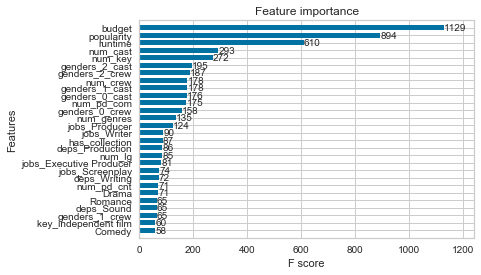

In [101]:
_=xgb.plot_importance(model_2, max_num_features=28, height=0.7)

According to the feature importance plot we have next top 3 features : budget, popularity and runtime. Below I create a dataframe with these features and revenue to show how it looks like.

In [102]:
#model_2.get_score(importance_type='gain')

In [103]:
ft_imp=pd.DataFrame(model_2.get_fscore().items(), columns=['feature','importance']).sort_values('importance', ascending=False)
ft_imp_2=ft_imp['feature'].iloc[:28].tolist()
ft_imp_2.extend(['revenue','predicted_revenue','title'])

In [104]:
pred = model_2.predict(dtest)

In [105]:
new_dataframe = pd.concat([X_test,y_test], axis=1, ignore_index=False)
new_dataframe=new_dataframe.reset_index()
new_dataframe = pd.concat([new_dataframe,pd.DataFrame(pred,columns=['predicted_revenue'])], axis=1, ignore_index=False)
new_dataframe = pd.merge(left=new_dataframe, right=train[['id','title']], how='left', left_on='id', right_on='id')
new_dataframe[ft_imp_2].head()

,budget,popularity,runtime,num_cast,num_key,genders_2_cast,genders_2_crew,genders_1_cast,num_crew,genders_0_cast,num_pd_com,genders_0_crew,num_genres,jobs_Producer,jobs_Writer,has_collection,deps_Production,num_lg,jobs_Executive Producer,jobs_Screenplay,deps_Writing,num_pd_cnt,Drama,genders_1_crew,deps_Sound,Romance,key_independent film,Comedy,revenue,predicted_revenue,title
0,3500000,0.556,90.000,11,2,3,2,5,2,3,1,0,1,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,16.040,14.407,Ringmaster
1,0,2.087,100.000,7,7,2,5,1,13,4,2,8,2,2,2,0,2,3,0,0,2,1,0,0,3,0,0,0,2.079,13.655,He-Man and She-Ra: The Secret of the Sword
2,2000000,1.189,89.000,3,1,2,0,1,1,0,1,1,3,0,0,0,0,1,0,0,0,1,1,0,0,0,1,1,10.425,11.509,Cowboys & Angels
3,98000000,7.284,119.000,31,6,20,12,2,16,9,4,2,2,4,0,0,6,2,1,2,4,4,0,2,0,0,0,0,16.120,18.579,Cutthroat Island
4,0,1.219,101.000,7,0,3,0,0,2,4,1,2,4,0,1,1,0,1,0,0,1,1,1,0,0,0,0,0,16.003,13.237,We Are from the Future 2
